<a href="https://colab.research.google.com/github/TomtheCodeBot/NIRInspection/blob/develop/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data gathering and preprocessing

**Attention**: due to the uncertainty of the data being given, i will only analyze the head and stem spectra of the mango since, as being reported by the research team at the University of natural science, the data from the stem is the most reliable. This is also to avoid the difference between spectras that might occurred when used with spectras from different parts of mangos.

This is a colab for the Mango Spectra Analysis project. In this colab, we will first try to analyze and bring out all the information that will be useful for future ML or DL models.

In the first few steps, we will use Savitzky-Golay filter with first derivative to capture the trends in each spectra. After that we shall use PCA to gather the PC of the raw and filterred data and graph the scores between the pca in order to find any information about this data set.

Then, if we cannot collect meaningful data, we will start using more advanced method such as O-PLS...

In [ ]:
%matplotlib inline
from matplotlib.widgets import Slider 

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.signal import savgol_filter

from sklearn.decomposition import PCA as sk_pca
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.utils.validation import check_consistent_length
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression as PLS
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from math import sqrt
from google.colab import widgets

<strong> Setting up Orthogonal Projection to Latent Structures (O-PLS) </strong>


This script was taken from BiRG.

Github link:https://github.com/BiRG/pyopls

In [ ]:
def polyfit(x, y):
    correlation_matrix = np.corrcoef(x, y)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2

    return r_squared

In [ ]:
def _center_scale_xy(X, Y, scale=True):
    """ Center X, Y and scale if the scale parameter==True
    Returns
    -------
        X, Y, x_mean, y_mean, x_std, y_std
    """
    # center
    x_mean = X.mean(axis=0)
    X -= x_mean
    y_mean = Y.mean(axis=0)
    Y -= y_mean
    # scale
    if scale:
        x_std = X.std(axis=0, ddof=1)
        x_std[x_std == 0.0] = 1.0
        X /= x_std
        y_std = Y.std(axis=0, ddof=1)
        y_std[y_std == 0.0] = 1.0
        Y /= y_std
    else:
        x_std = np.ones(X.shape[1])
        y_std = np.ones(Y.shape[1])
    return X, Y, x_mean, y_mean, x_std, y_std

    
class OPLS(BaseEstimator, TransformerMixin):
    """Orthogonal Projection to Latent Structures (O-PLS)
    This class implements the O-PLS algorithm for one (and only one) response as described by [Trygg 2002].
    This is equivalent to the implementation of the libPLS MATLAB library (http://libpls.net/)
    Parameters
    ----------
    n_components: int, number of orthogonal components to filter. (default 5).
    scale: boolean, scale data? (default True)
    Attributes
    ----------
    W_ortho_ : weights orthogonal to y
    P_ortho_ : loadings orthogonal to y
    T_ortho_ : scores orthogonal to y
    x_mean_ : mean of the X provided to fit()
    y_mean_ : mean of the Y provided to fit()
    x_std_ : std deviation of the X provided to fit()
    y_std_ : std deviation of the Y provided to fit()
    References
    ----------
    Johan Trygg and Svante Wold. Orthogonal projections to latent structures (O-PLS).
    J. Chemometrics 2002; 16: 119-128. DOI: 10.1002/cem.695
    """
    def __init__(self, n_components=10, scale=True):
        self.n_components = n_components
        self.scale = scale

        self.W_ortho_ = None
        self.P_ortho_ = None
        self.T_ortho_ = None

        self.x_mean_ = None
        self.y_mean_ = None
        self.x_std_ = None
        self.y_std_ = None

    def fit(self, X, Y):
        """Fit model to data
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of predictors.
        Y : array-like, shape = [n_samples, 1]
            Target vector, where n_samples is the number of samples.
            This implementation only supports a single response (target) variable.
        """

        # copy since this will contains the residuals (deflated) matrices
        check_consistent_length(X, Y)
        X = check_array(X, dtype=np.float64, copy=True, ensure_min_samples=2)
        Y = check_array(Y, dtype=np.float64, copy=True, ensure_2d=False)
        if Y.ndim == 1:
            Y = Y.reshape(-1, 1)

        X, Y, self.x_mean_, self.y_mean_, self.x_std_, self.y_std_ = _center_scale_xy(X, Y, self.scale)

        Z = X.copy()
        w = np.dot(X.T, Y)  # calculate weight vector
        w /= np.linalg.norm(w)  # normalize weight vector

        W_ortho = []
        T_ortho = []
        P_ortho = []

        for i in range(self.n_components):
            t = np.dot(Z, w)  # scores vector
            p = np.dot(Z.T, t) / np.dot(t.T, t).item()  # loadings of X
            w_ortho = p - np.dot(w.T, p).item() / np.dot(w.T, w).item() * w  # orthogonal weight
            w_ortho = w_ortho / np.linalg.norm(w_ortho)  # normalize orthogonal weight
            t_ortho = np.dot(Z, w_ortho)  # orthogonal components
            p_ortho = np.dot(Z.T, t_ortho) / np.dot(t_ortho.T, t_ortho).item()
            Z -= np.dot(t_ortho, p_ortho.T)
            W_ortho.append(w_ortho)
            T_ortho.append(t_ortho)
            P_ortho.append(p_ortho)

        self.W_ortho_ = np.hstack(W_ortho)
        self.T_ortho_ = np.hstack(T_ortho)
        self.P_ortho_ = np.hstack(P_ortho)

        return self

    def transform(self, X):
        """Get the non-orthogonal components of X (which are considered in prediction).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Training or test vectors, where n_samples is the number of samples and
            n_features is the number of predictors (which should be the same predictors the model was trained on).
        Returns
        -------
        X_res, X with the orthogonal data filtered out
        """
        Z = check_array(X, copy=True)

        Z -= self.x_mean_
        if self.scale:
            Z /= self.x_std_

        # filter out orthogonal components of X
        for i in range(self.n_components):
            t = np.dot(Z, self.W_ortho_[:, i]).reshape(-1, 1)
            Z -= np.dot(t, self.P_ortho_[:, i].T.reshape(1, -1))

        return Z

    def fit_transform(self, X, y=None, **fit_params):
        """ Learn and apply the filtering on the training data and get the filtered X
        Parameters
        ----------
        X : array-like, shape=[n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of predictors.
        y : array-like, shape = [n_samples, 1]
            Target vector, where n_samples is the number of samples.
            This O-PLS implementation only supports a single response (target) variable.
            Y=None will raise ValueError from fit().
        Returns
        -------
        X_filtered
        """
        return self.fit(X, y).transform(X)

    def score(self, X):
        """ Return the coefficient of determination R^2X of the transformation.
        Parameters
        ----------
          X : array-like of shape (n_samples, n_features)
              Test samples. For some estimators this may be a
              precomputed kernel matrix or a list of generic objects instead,
              shape = (n_samples, n_samples_fitted),
              where n_samples_fitted is the number of
              samples used in the fitting for the estimator.
          Returns
          -------
          score : float
              The amount of variation in X explained by the transformed X. A lower number indicates more orthogonal
              variation has been removed.
        """
        X = check_array(X)
        Z = self.transform(X)
        return np.sum(np.square(Z)) / np.sum(np.square(X - self.x_mean_))  # Z is already properly centered


<strong>Setting up Multiplicative Scatter
Correction</strong>

The math and snippets of codes that helped me to program the MSC class are here:

- Loopy MSC: A Simple Way to Improve Multiplicative Scatter
Correction:https://www.researchgate.net/publication/23390629_Loopy_MSC_A_Simple_Way_to_Improve_Multiplicative_Scatter_Correction
- Preprospectra: https://github.com/dijsilva/preprocspectra
- Multiplicative Scatter Correction details:https://www.labcognition.com/onlinehelp/en/multiplicative_scatter_correction.htm

In [ ]:
class MSC():
    def __init__(self):
        self.mean=None
        self._fitted = False
    def fit(self,X, y = None):
        ### finding means
        X = np.array(X)
        self.mean = X.mean(axis=0)
        self._fitted = True
    def transform(self,X):
        num_rows,_ = X.shape
        retX=np.zeros(X.shape)
        for i in range(0,num_rows):
            fit = np.polyfit(self.mean, X[i], deg=1, full=True)
            retX[i] =  (X[i]- fit[0][1]) / fit[0][0]
        return retX

<strong> Standardization of the data</strong>

Some of the processing technics like PCA and O-PLS requires standardization of the data. The class bellow helps to scale the data while also keep the means and standard deviation to use for new data

In [ ]:
class standardScaler(object):
    
    def __init__(self,with_mean=True, with_std=True, normfact=1.0):
        ### initializing variables
        self._with_mean = with_mean
        self._with_std = with_std
        self.std = None
        self.normfact=normfact
        self.mean = None
        self._fitted = False
        
    def fit(self,X, y = None):
        ### finding means and standard deviation 
        X = np.array(X)
        self.mean = X.mean(axis=0)
        self.std = X.std(axis=0)
        self._fitted = True
        
    def transform(self,X, y=None):
        ### using means and standard deviation to standardize tge data
        if self._fitted:
            X = np.array(X)
            if self._with_mean:
                X=X-self.mean
            if self._with_std:
                X=X/(self.std*self.normfact)
            return X
        else:
            print("Scaler is not fitted")
            return
            
    def fit_transform(self,X, y=None):
        self.fit(X)
        return self.transform(X)


<strong>Mean Absolute Percentage Error</strong>

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true=np.transpose(y_true)
    return (np.sum(np.abs((y_true[0]- y_pred) / y_true[0]))) /len(y_pred)

<strong>Loading data</strong>

Load the spectrum data from .csv file.

Note: as mentioned above, only the stem spectra of the mango is observed


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving mangodataHead-Stem2.csv to mangodataHead-Stem2.csv


In [ ]:
import io
data_pd= pd.read_csv(io.BytesIO(uploaded['mangodataHead-Stem2.csv']),dtype=float)

data=data_pd.to_numpy(dtype=float)
data_pd

,901.187608,905.10287,909.013972,912.920914,916.823696,920.722317,925.914007,929.802921,933.687675,937.568269,941.444702,945.316975,949.185088,953.04904,956.908832,960.764464,964.615936,968.463247,973.586524,977.424129,981.257573,985.086856,988.911979,992.732943,996.549745,1000.362388,1004.17087,1007.975192,1011.775354,1015.571355,1019.363197,1024.412513,1028.194647,1031.972621,1035.746434,1039.516088,1043.28158,1047.042913,1050.800085,1054.553098,...,1592.176229,1595.271919,1598.363449,1601.450819,1605.56084,1608.638503,1611.712005,1614.781347,1617.846528,1620.90755,1623.964411,1627.017111,1630.065652,1633.110032,1636.150252,1639.186312,1642.218212,1646.254273,1649.276465,1652.294497,1655.308369,1658.31808,1661.323631,1664.325022,1667.322253,1670.315323,1673.304233,1676.288983,1679.269572,1683.23722,1686.208103,1689.174825,1692.137386,1695.095788,1698.050029,1701.00011,Dry matter,Sugar,Brix,Acidity
0,25462.0,30949.0,35200.0,38686.0,41791.0,47117.0,54975.0,61210.0,68535.0,74815.0,80153.0,84921.0,89827.0,94002.0,97566.0,102208.0,106776.0,111694.0,118179.0,122662.0,126482.0,130999.0,134462.0,137508.0,139935.0,142395.0,144457.0,145695.0,147020.0,148015.0,149336.0,150302.0,150859.0,151776.0,151970.0,152508.0,152848.0,153693.0,153897.0,154594.0,...,86979.0,86167.0,84345.0,83311.0,82141.0,80636.0,79441.0,78569.0,77131.0,75312.0,74115.0,72715.0,70750.0,69463.0,67626.0,66886.0,65024.0,62155.0,60413.0,58328.0,56782.0,54255.0,51888.0,49585.0,46597.0,43480.0,39371.0,34819.0,30520.0,25426.0,21120.0,18077.0,15108.0,12295.0,10989.0,9193.0,15.64,461.69,8.53,2.36
1,24118.0,29627.0,33712.0,36520.0,40797.0,45192.0,52865.0,59487.0,65873.0,71951.0,77129.0,82151.0,86471.0,90477.0,94627.0,98628.0,103242.0,107943.0,113929.0,118619.0,122669.0,126760.0,130171.0,133154.0,135362.0,138172.0,139984.0,141287.0,142172.0,143525.0,144502.0,144907.0,145885.0,146131.0,146899.0,147536.0,147820.0,148559.0,148933.0,149201.0,...,86932.0,86043.0,84908.0,83776.0,81935.0,80906.0,79700.0,78369.0,76985.0,75820.0,74024.0,72569.0,71114.0,69274.0,67964.0,66377.0,64326.0,62606.0,60418.0,58311.0,56705.0,54496.0,51945.0,49614.0,46735.0,42729.0,38878.0,34769.0,30237.0,24639.0,20760.0,17792.0,15276.0,12538.0,10360.0,9088.0,16.32,461.69,8.53,2.36
2,24574.0,30190.0,33905.0,36707.0,41073.0,45650.0,53007.0,58860.0,65709.0,71399.0,76800.0,82340.0,86449.0,90933.0,94063.0,98888.0,103262.0,107597.0,113878.0,118513.0,122496.0,126453.0,129958.0,133623.0,135384.0,138076.0,139622.0,141252.0,142799.0,143785.0,144995.0,145923.0,145957.0,147337.0,147906.0,147772.0,148279.0,149002.0,149421.0,149670.0,...,81072.0,80199.0,79428.0,78254.0,76596.0,75744.0,74700.0,73541.0,71722.0,71232.0,69704.0,68246.0,66998.0,65519.0,64116.0,62481.0,60878.0,59069.0,57122.0,55325.0,53261.0,51749.0,49586.0,47343.0,45126.0,41527.0,38434.0,34509.0,30543.0,24220.0,21350.0,16953.0,15339.0,12565.0,10626.0,9066.0,17.65,520.78,9.17,2.29
3,25657.0,31679.0,36419.0,39600.0,43799.0,47928.0,55767.0,63251.0,70163.0,76283.0,82499.0,87765.0,92833.0,96916.0,100994.0,105224.0,110090.0,114879.0,121862.0,126299.0,130484.0,135046.0,138745.0,142387.0,144456.0,147019.0,148820.0,150291.0,151889.0,152964.0,153767.0,154717.0,155840.0,156092.0,157294.0,157138.0,157541.0,157916.0,158119.0,159181.0,...,91752.0,90252.0,89760.0,88324.0,86660.0,85541.0,84664.0,82761.0,81785.0,79982.0,78756.0,76913.0,75846.0,73555.0,72226.0,70660.0,69001.0,66726.0,64748.0,62716.0,60886.0,58534.0,56395.0,53556.0,50705.0,47049.0,43047.0,38300.0,33883.0,27713.0,23200.0,19900.0,16704.0,14479.0,12099.0,10131.0,17.21,520.78,9.17,2.29
4,21693.0,25851.0,30013.0,32869.0,36028.0,40170.0,46477.0,52435.0,58218.0,63191.0,68408.0,72650.0,77073.0,79945.0,83784.0,87485.0,91356.0,95156.0,100161.0,104858.0,108327.0,111451.0,114841.0,117550.0,119797.0,121824.0,123567.0,125023.0,126173.0,127449.0,128014.0,128702.0,129215.0,130866.0,130769.0,131232.0,131582.0,131912.0,132445.0,132513.0,...,71491.0,70601.0,69434.0,68866.0,67437.0,66325.0,65850.0,64763.0,63518.0,62411.0,61850.0,60094.0

<strong>Spliting data</strong>

Spliting data into left and right side, for measurements in one side or both side of the mango if needed

In [ ]:
### Splitting the the mango spectra data to 2 parts: facing left and facing right.
### Getting the right side of the mango:

X = data[:,0:227]
Y = data[:,230]
"""mscX= MSC()
mscX.fit(X)
X = mscX.transform(X)"""


### Getting the right side of the mango
### The right side of the mango in this dataset is typically in even order:
Xright = []
Yright = []
for i in range(len(X)):
    if i%2==0:
        Xright.append(X[i])
        Yright.append(Y[i])
Xright = np.array(Xright)
Yright = np.array(Yright)

### Getting the left side of the mango:
### The right side of the mango in this dataset is typically in odd order
Xleft = []
Yleft = []
for i in range(len(X)):
    if i%2==1:
        Xleft.append(X[i])
        Yleft.append(Y[i])
Xleft = np.array(Xleft)
Yleft = np.array(Yleft)

In [ ]:
Xright.shape

(46, 227)

<strong> Calculating the first derivative </strong>

Using Savitzky-Golay to smooth and calculating derivative of the data in order to see the underlying changes in wavelengths.

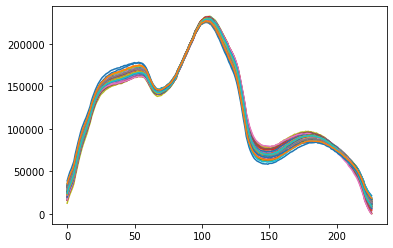

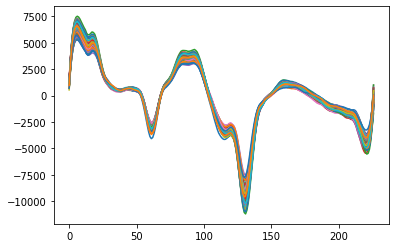

In [ ]:
### Calcualte first derivative using Savitzky-Golay filter
### more details of this method is in this link
### URL:https://www.kaggle.com/phamvanvung/nir-spectra-classification-using-pca?fbclid=IwAR2yefA_IQhq4OKpgHehJP8WKFJYq7MW2LEMm5hNWvGPp5iYBdOuKuUe4dg

dX = savgol_filter(data[:,0:227], 25, polyorder = 5, deriv = 1)

plt.plot(X.T)
plt.show()
plt.plot(dX.T)
plt.show()


#PCA method

One of the methods that we will try is PCA, or Principal Component Analysis. This method involves reducing the dimension of the data while explaining most of the data's information. One can think about how the method works as higher dimension's projection on the lower dimension's plane so that one can trace back to higher dimension's information using lower dimension's information without losing much data .

In this case, we will be taking the first 10 Principal Components and look into it to see whether we can get any correlation between the PCs and the Dependent variable or not.


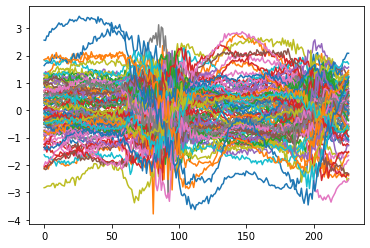

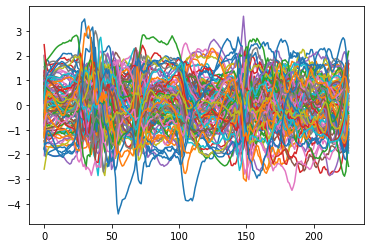

In [ ]:
### Initialise
skpca1 = sk_pca(n_components = 10)
skpca2 = sk_pca(n_components = 10)

### Standardized the data
### This is important when correlating data with very different variances
nfeat1 = standardScaler().fit_transform(X)
nfeat2 = standardScaler().fit_transform(dX)

### Plotting the data
plt.plot(nfeat1.T, label='feature')
plt.show()
plt.plot(nfeat2.T, label='derrivative')
plt.show()

<strong>Getting the eigenvalues </strong>

After calculating the eigenvector, we can see how much the the data being explained using eigenvalues. Below are explained ratios of the two datasets we just fit the model with


In [ ]:
# Fit the spectral data and extract the explained variance ratio
X1 = skpca1.fit(nfeat1.T)
expl_var_1 = X1.explained_variance_ratio_
print(expl_var_1)

[0.76024789 0.15402957 0.0271539  0.0222844  0.00889218 0.00346893
 0.00216887 0.00140197 0.00130156 0.00112091]


In [ ]:
# Fit the first derrivative data and extract the explained variance ratio
X2 = skpca2.fit(nfeat2.T)
expl_var_2 = X2.explained_variance_ratio_
print(expl_var_2)

[0.5130264  0.26731505 0.06032877 0.02745824 0.02603781 0.0180045
 0.01210137 0.00932388 0.00859428 0.00622253]


We then plot the data to see the differences between the dataset.

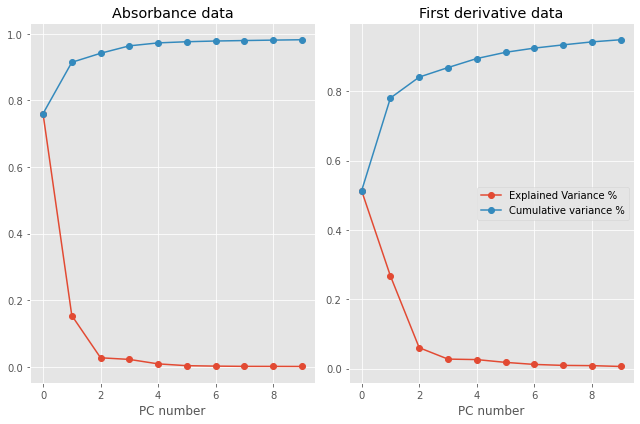

In [ ]:
# Plot data
with plt.style.context('ggplot'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
    fig.set_tight_layout(True)
    
    ax1.plot(expl_var_1, '-o', label = "Explained Variance %")
    ax1.plot(np.cumsum(expl_var_1),'-o', label='Cumulative variance %')
    ax1.set_xlabel("PC number")
    ax1.set_title("Absorbance data")
    
    ax2.plot(expl_var_2, '-o', label="Explained Variance %")
    ax2.plot(np.cumsum(expl_var_2), '-o', label='Cumulative variance %')
    ax2.set_xlabel("PC number")
    ax2.set_title("First derivative data")
    
    plt.legend()
    plt.show()

<strong>Plotting the Principal Components</strong>

Once we got PCs, we can plot each of them on a graph with each other to see the scores between them, or we can plot them on with the Dependent variables to see whichs PCs can explain data the clearest.

Plotting the Principal Components together:

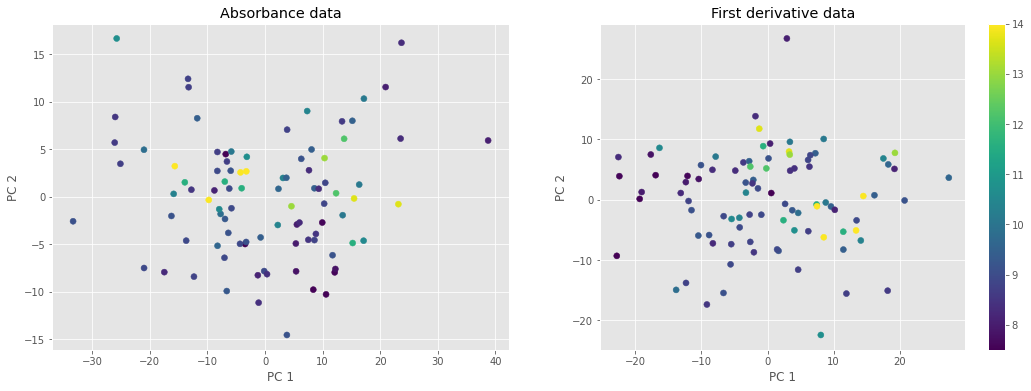

In [ ]:
skpca1 = sk_pca(n_components = 10)
skpca2 = sk_pca(n_components = 10)
X1 = skpca1.fit(nfeat1)
X2 = skpca2.fit(nfeat2)
fit1= X1.fit_transform(nfeat1)
fit2= X2.fit_transform(nfeat2)
with plt.style.context('ggplot'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    fig.set_tight_layout(False)
    
    CS=ax1.scatter(np.transpose(fit1)[0],np.transpose(fit1)[1],c=Y)
    ax1.set_xlabel("PC 1")
    ax1.set_ylabel("PC 2")
    CS2=ax2.scatter(np.transpose(fit2)[0],np.transpose(fit2)[1],c=Y)
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")
    ax1.set_title("Absorbance data")
    ax2.set_title("First derivative data")


    fig.colorbar(CS)
    plt.show()

Plotting the transformed data with the Dependent variables:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

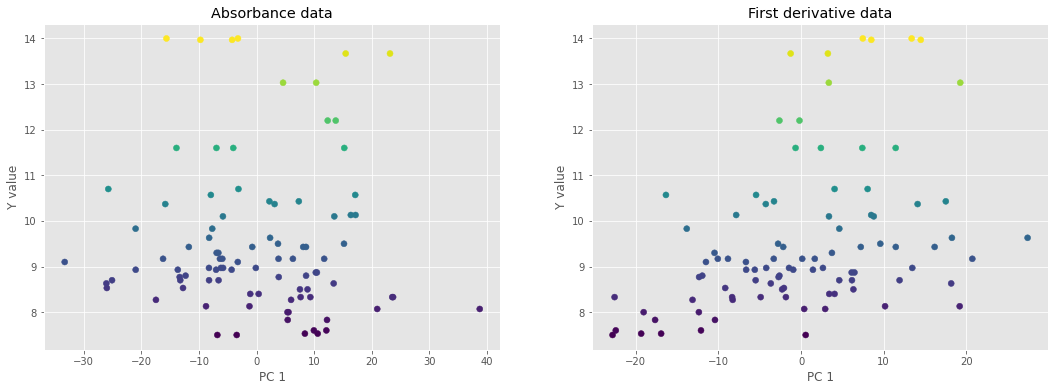

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

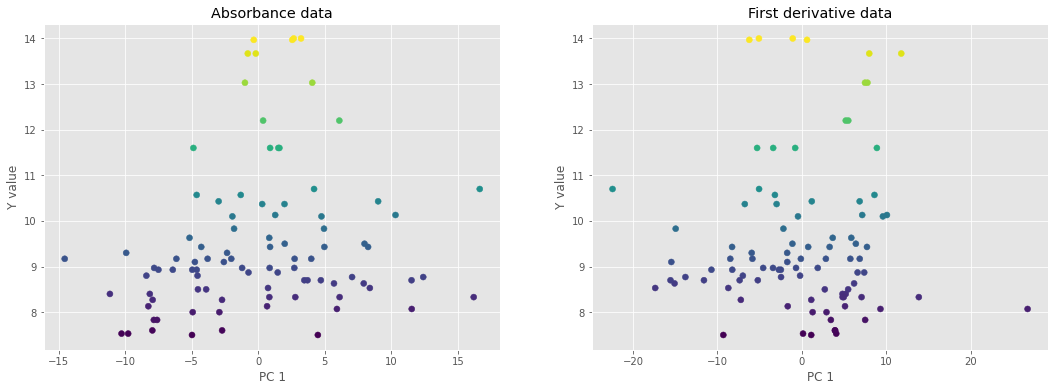

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

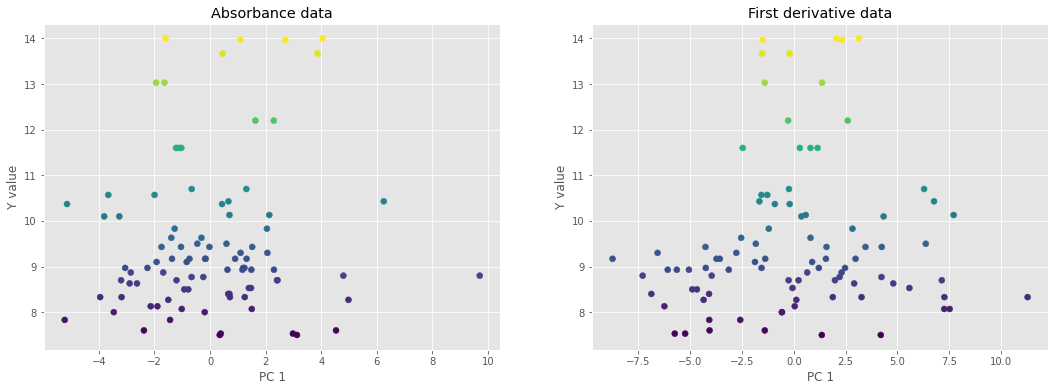

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

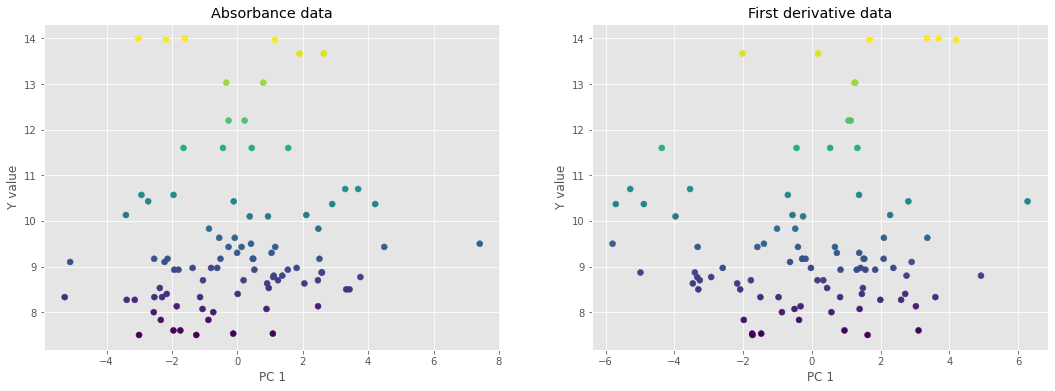

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

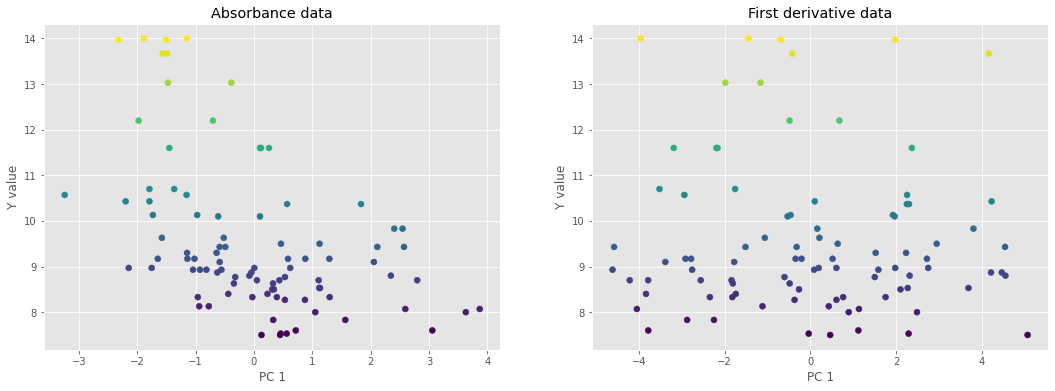

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

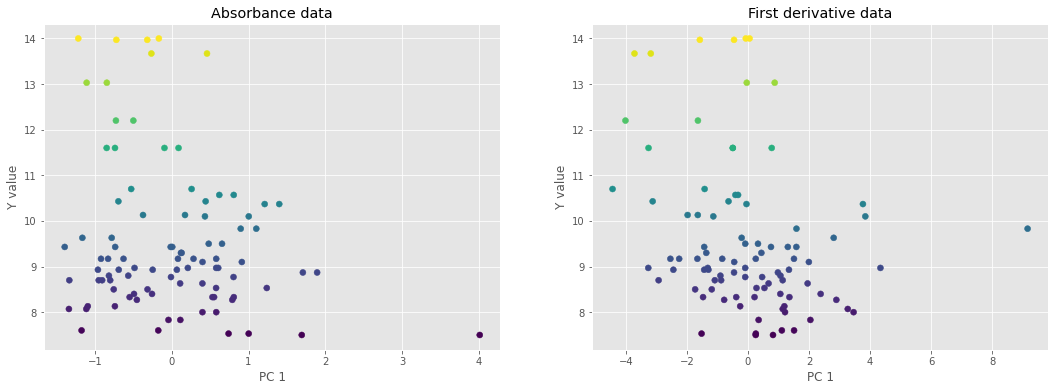

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

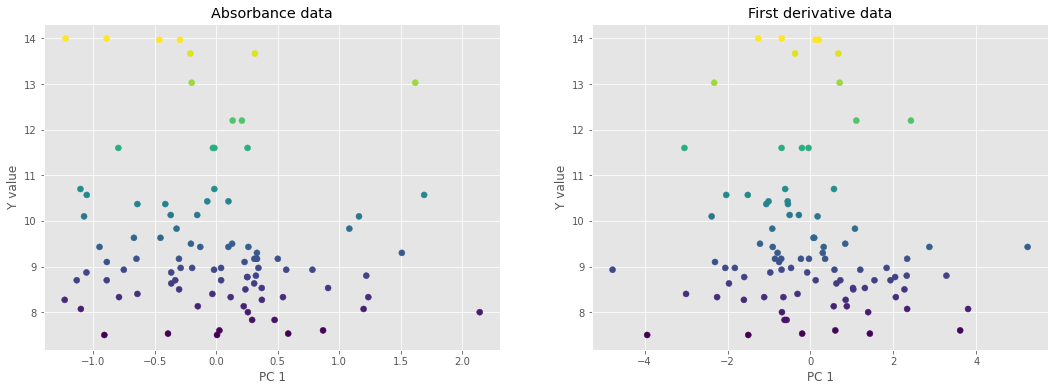

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

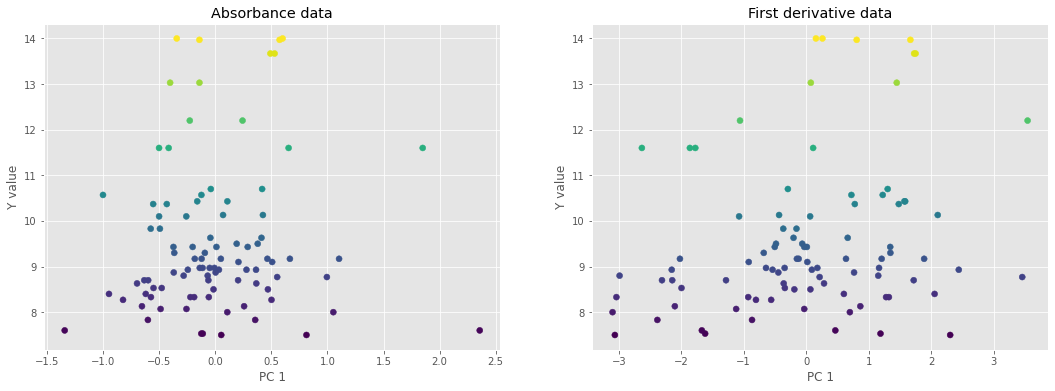

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

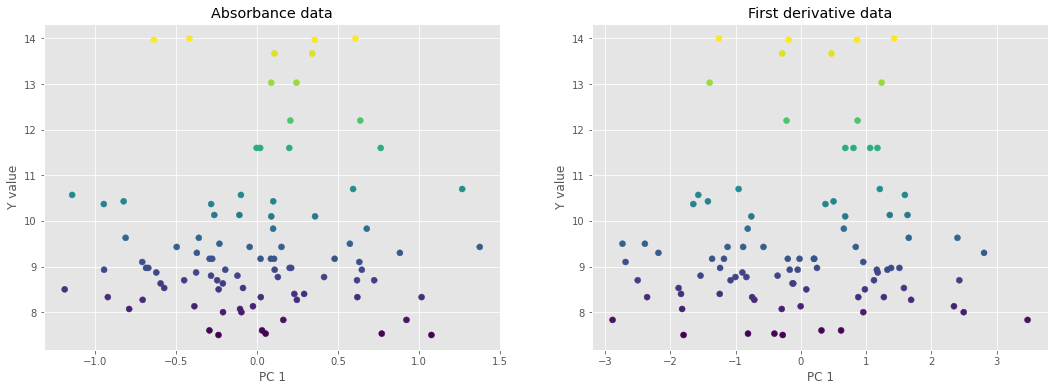

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

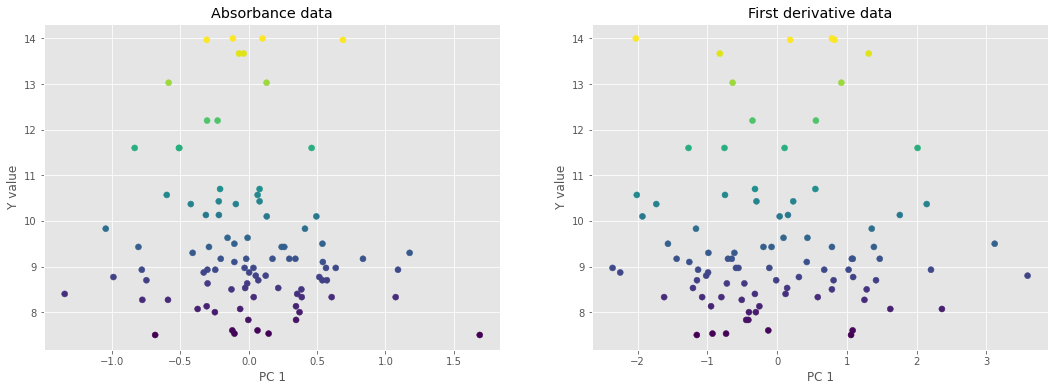

<IPython.core.display.Javascript object>

In [ ]:
skpca1 = sk_pca(n_components = 10)
skpca2 = sk_pca(n_components = 10)
X1 = skpca1.fit(nfeat1)
X2 = skpca2.fit(nfeat2)
fit1= X1.fit_transform(nfeat1)
fit2= X2.fit_transform(nfeat2)
tb = widgets.TabBar([str(i) for i in range(10)])
for i in range(10):
    with tb.output_to(i, select=(i < 3)):
        with plt.style.context('ggplot'):
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
            fig.set_tight_layout(False)
            
            ax1.scatter(np.transpose(fit1)[i],Y,c=Y)
            ax1.set_xlabel("PC 1")
            ax1.set_ylabel("Y value")
            ax2.scatter(np.transpose(fit2)[i],Y,c=Y)
            ax2.set_xlabel("PC 1")
            ax2.set_ylabel("Y value")
            ax1.set_title("Absorbance data")
            ax2.set_title("First derivative data")

Applying linear regression to the dataset for later comparison.

R^2 of the normal data is 0.3771261320968668
R^2 of the derivative 1 data is 0.3506752267788062
MSE of the normal data is 1.6819479833726716
MSE of the derivative 1 data is 1.7533734342554692
RMSE of the normal data is 1.2968993728785096
RMSE of the derivative 1 data is 1.3241500799590162
MAE of the normal data is 1.0425481788270923
MAE of the derivative 1 data is 1.0285465559361497
MAPE of the normal data is 0.14267624493217698
MAPE of the derivative 1 data is 0.13789060562747332
(10, 92)


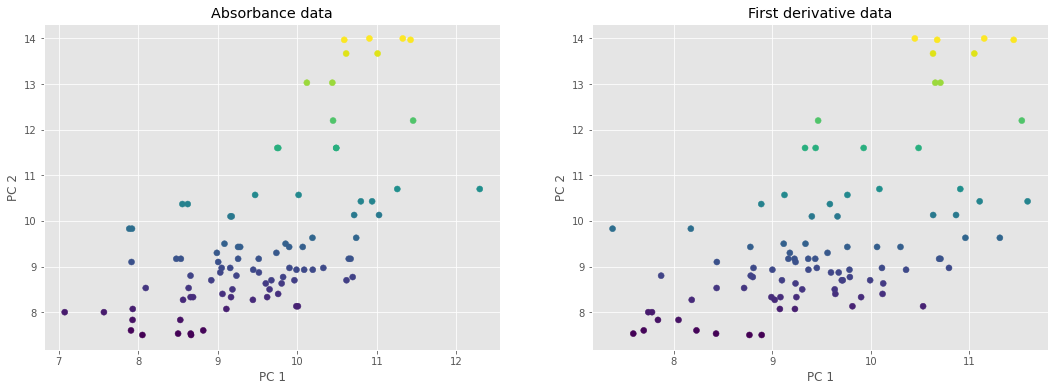

In [ ]:
linearfit1 =LinearRegression()
linearfit2 = LinearRegression()

linearfit1.fit(fit1,Y)
linearfit2.fit(fit2,Y)

Ypred=linearfit1.predict(fit1)
dYpred=linearfit2.predict(fit2)
print("R^2 of the normal data is "+str(polyfit(Ypred,Y)))
print("R^2 of the derivative 1 data is "+str(polyfit(dYpred,Y)))

print("MSE of the normal data is "+str(mean_squared_error(Ypred,Y)))
print("MSE of the derivative 1 data is "+str(mean_squared_error(dYpred,Y)))

print("RMSE of the normal data is "+str(sqrt(mean_squared_error(Ypred,Y))))
print("RMSE of the derivative 1 data is "+str(sqrt(mean_squared_error(dYpred,Y))))

print("MAE of the normal data is "+str(mean_absolute_error(Ypred,Y)))
print("MAE of the derivative 1 data is "+str(mean_absolute_error(dYpred,Y)))

print("MAPE of the normal data is "+str(mean_absolute_percentage_error(Ypred,Y)))
print("MAPE of the derivative 1 data is "+str(mean_absolute_percentage_error(dYpred,Y)))



with plt.style.context('ggplot'):
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
      fig.set_tight_layout(False)
      print(fit1.T.shape)
      CS=ax1.scatter(Ypred,Y,c=Y)
      ax1.set_xlabel("PC 1")
      ax1.set_ylabel("PC 2")
      CS2=ax2.scatter(dYpred,Y,c=Y)
      ax2.set_xlabel("PC 1")
      ax2.set_ylabel("PC 2")
      ax1.set_title("Absorbance data")
      ax2.set_title("First derivative data")
      plt.show()

The same procedure will be done on the left side of the mango data and the right side of the mango data.

 All the step below have been explained above. 

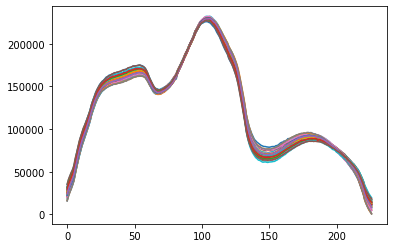

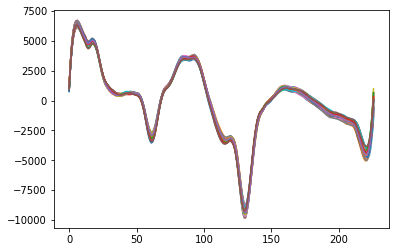

In [ ]:
# Calcualte first derivative applying a Savitzky-Golay filter
dXleft = savgol_filter(Xleft, 25, polyorder = 5, deriv = 1)

plt.plot(Xleft.T, label='feature')
plt.show()
plt.plot(dXleft.T, label='derrivative')
plt.show()

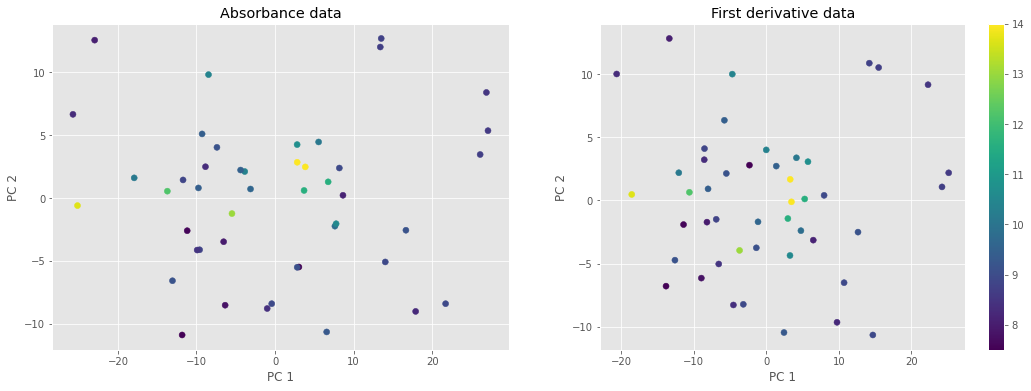

In [ ]:
# Initialise
skpca1 = sk_pca(n_components = 10)
skpca2 = sk_pca(n_components = 10)

# Scale the features to have zero mean and standard deviation of 1
# This is important when correlating data with very different variances
nfeat1left = standardScaler().fit_transform(Xleft)
nfeat2left = standardScaler().fit_transform(dXleft)

X1 = skpca1.fit(nfeat1left)
X2 = skpca2.fit(nfeat2left)
fit1= X1.fit_transform(nfeat1left)
fit2= X2.fit_transform(nfeat2left)
with plt.style.context('ggplot'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    fig.set_tight_layout(False)
    
    CS=ax1.scatter(np.transpose(fit1)[0],np.transpose(fit1)[1],c=Yleft)
    ax1.set_xlabel("PC 1")
    ax1.set_ylabel("PC 2")
    CS2=ax2.scatter(np.transpose(fit2)[0],np.transpose(fit2)[1],c=Yleft)
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")
    ax1.set_title("Absorbance data")
    ax2.set_title("First derivative data")


    fig.colorbar(CS)
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

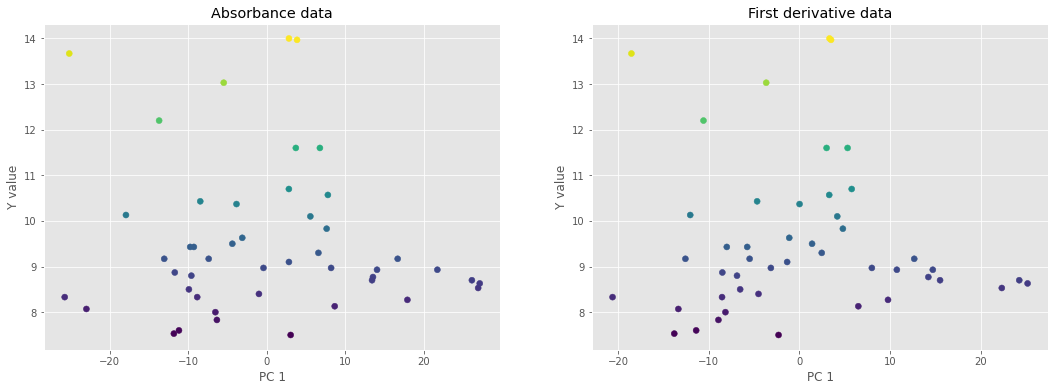

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

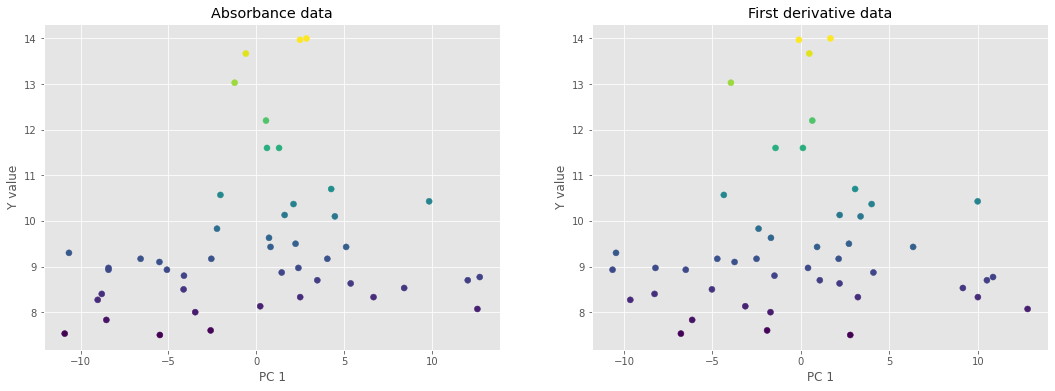

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

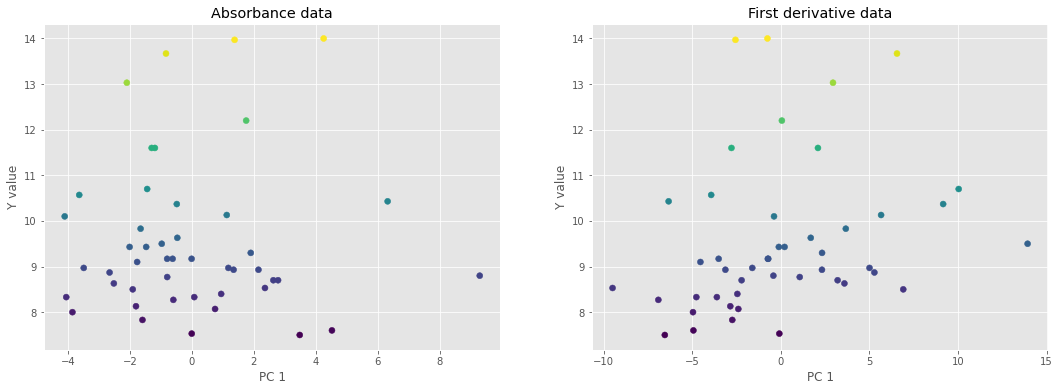

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

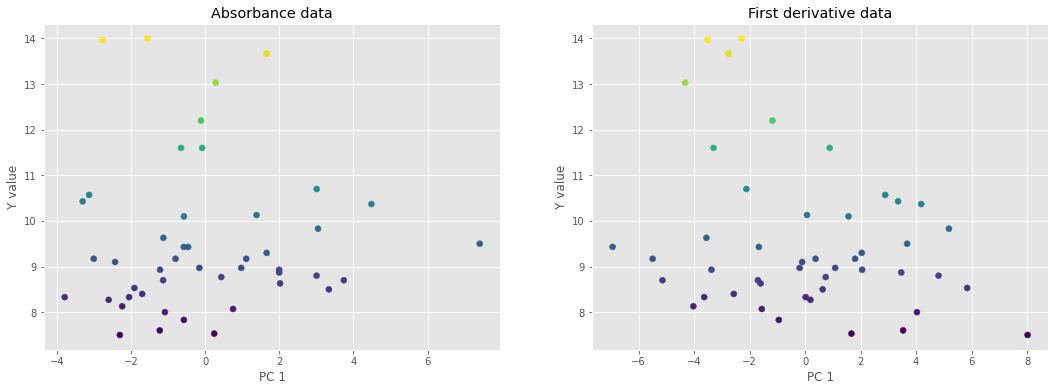

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

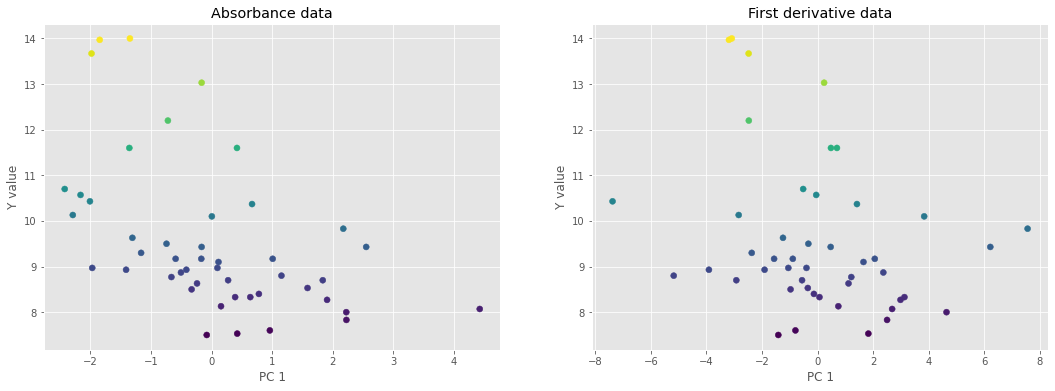

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

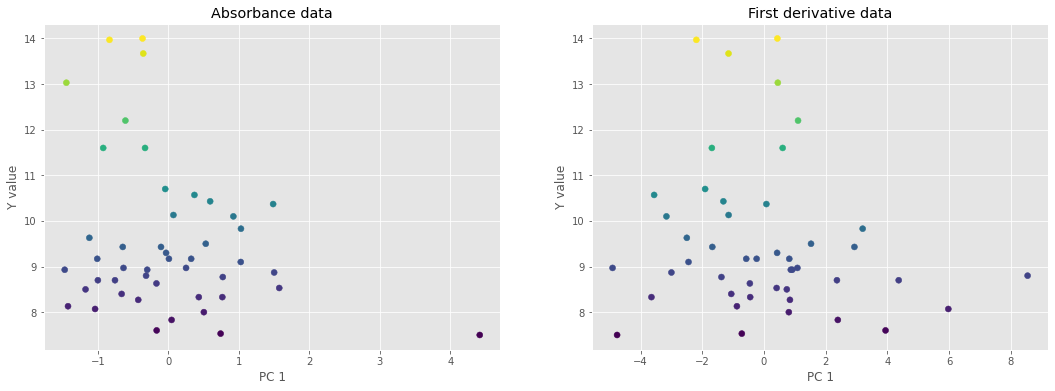

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

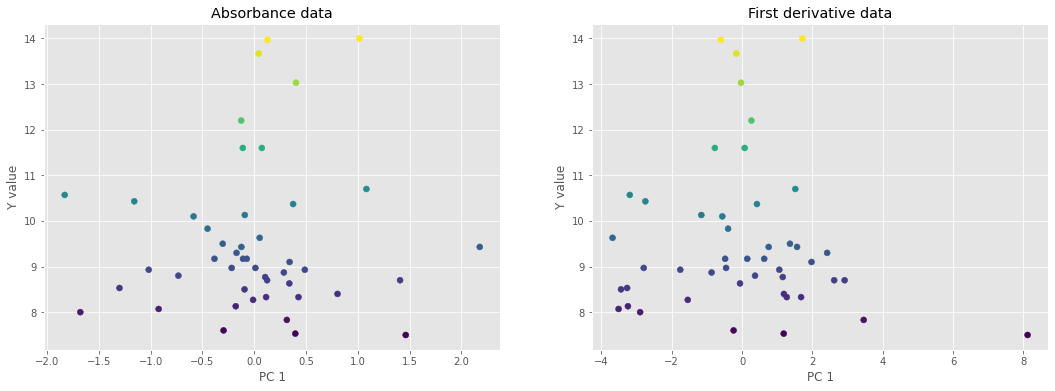

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

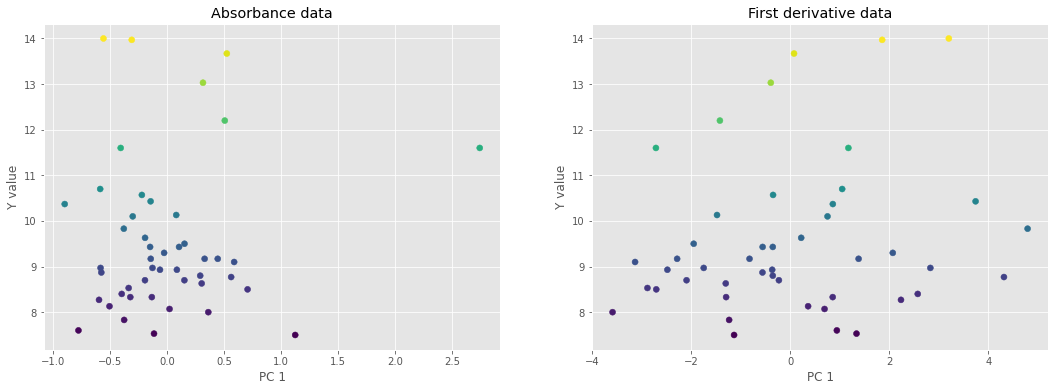

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

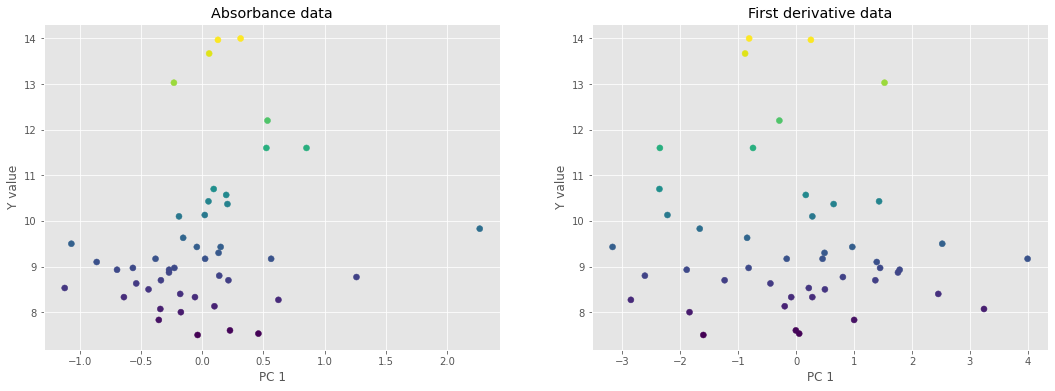

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

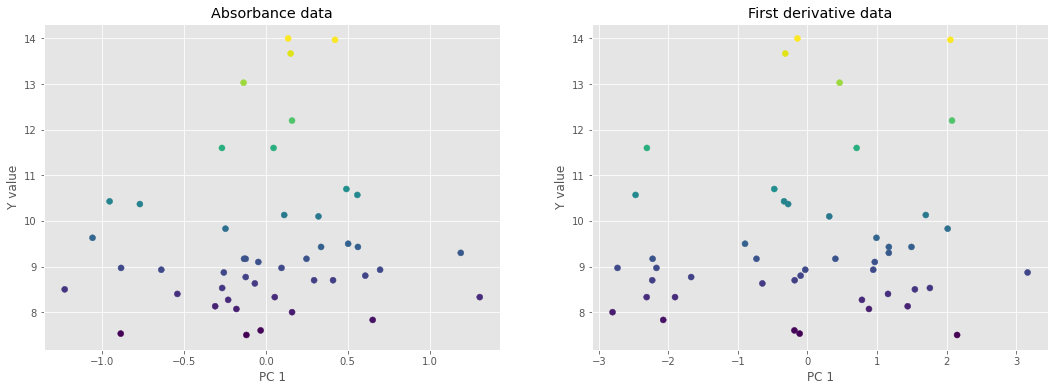

<IPython.core.display.Javascript object>

In [ ]:
skpca1 = sk_pca(n_components = 10)
skpca2 = sk_pca(n_components = 10)
X1 = skpca1.fit(nfeat1left)
X2 = skpca2.fit(nfeat2left)
fit1= X1.fit_transform(nfeat1left)
fit2= X2.fit_transform(nfeat2left)
tb = widgets.TabBar([str(i) for i in range(10)])
for i in range(10):
    with tb.output_to(i, select=(i < 3)):
        with plt.style.context('ggplot'):
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
            fig.set_tight_layout(False)
            
            ax1.scatter(np.transpose(fit1)[i],Yleft,c=Yleft)
            ax1.set_xlabel("PC 1")
            ax1.set_ylabel("Y value")
            ax2.scatter(np.transpose(fit2)[i],Yleft,c=Yleft)
            ax2.set_xlabel("PC 1")
            ax2.set_ylabel("Y value")
            ax1.set_title("Absorbance data")
            ax2.set_title("First derivative data")

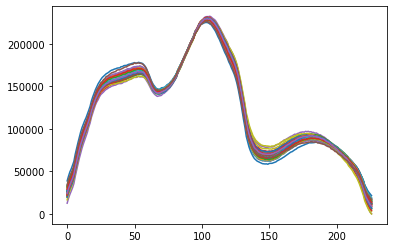

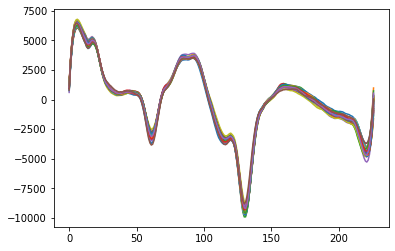

In [ ]:
# Calcualte first derivative applying a Savitzky-Golay filter
dXright = savgol_filter(Xright, 25, polyorder = 5, deriv = 1)

plt.plot(Xright.T, label='feature')
plt.show()
plt.plot(dXright.T, label='derrivative')
plt.show()

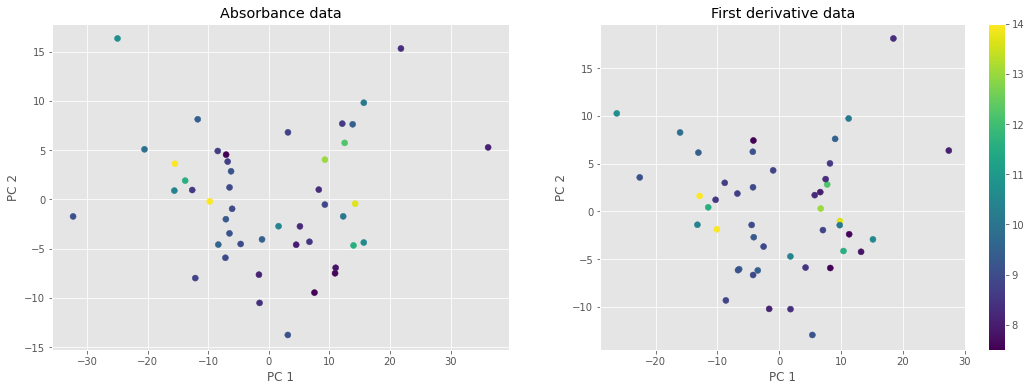

In [ ]:
# Initialise
skpca1 = sk_pca(n_components = 10)
skpca2 = sk_pca(n_components = 10)

# Scale the features to have zero mean and standard deviation of 1
# This is important when correlating data with very different variances
nfeat1right = standardScaler().fit_transform(Xright)
nfeat2right = standardScaler().fit_transform(dXright)

X1 = skpca1.fit(nfeat1right)
X2 = skpca2.fit(nfeat2right)
fit1= X1.fit_transform(nfeat1right)
fit2= X2.fit_transform(nfeat2right)
with plt.style.context('ggplot'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    fig.set_tight_layout(False)
    CS=ax1.scatter(np.transpose(fit1)[0],np.transpose(fit1)[1],c=Yright)
    ax1.set_xlabel("PC 1")
    ax1.set_ylabel("PC 2")
    CS2=ax2.scatter(np.transpose(fit2)[0],np.transpose(fit2)[1],c=Yright)
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")
    ax1.set_title("Absorbance data")
    ax2.set_title("First derivative data")

    fig.colorbar(CS)
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

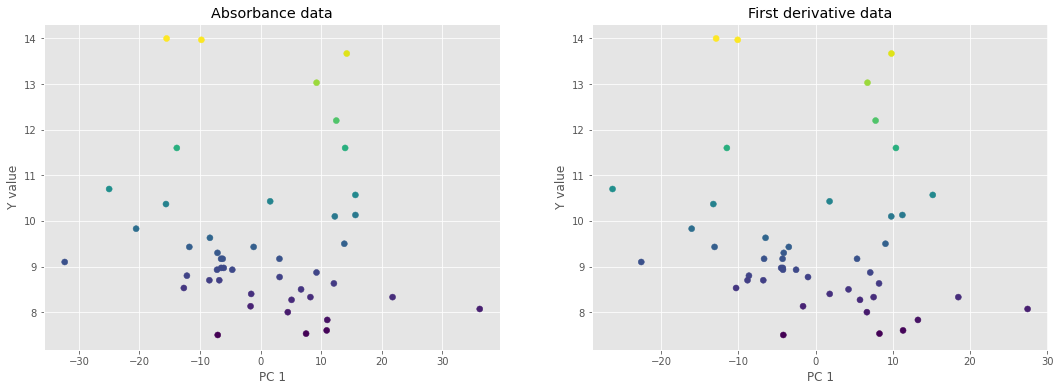

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

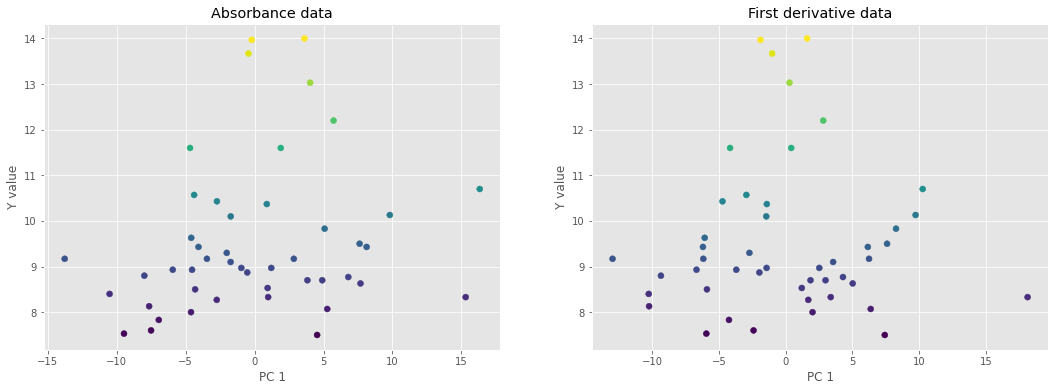

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

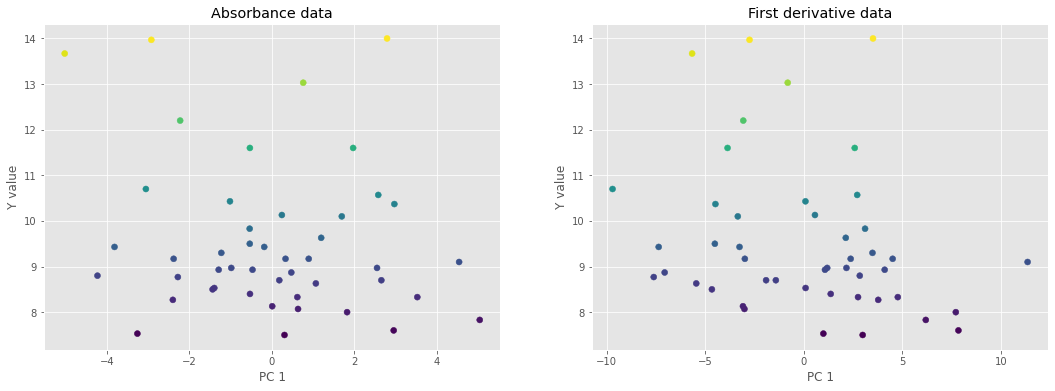

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

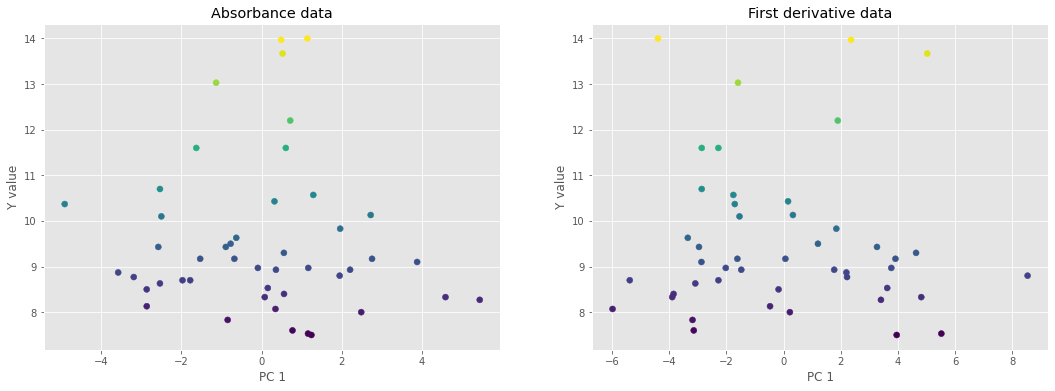

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

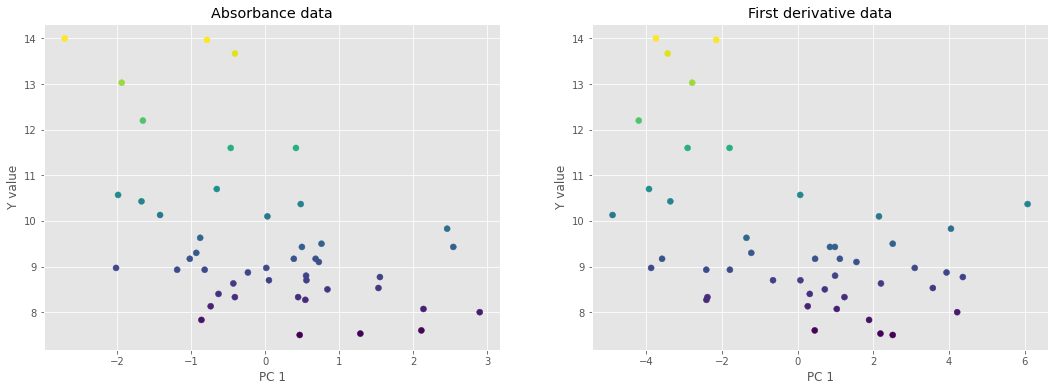

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

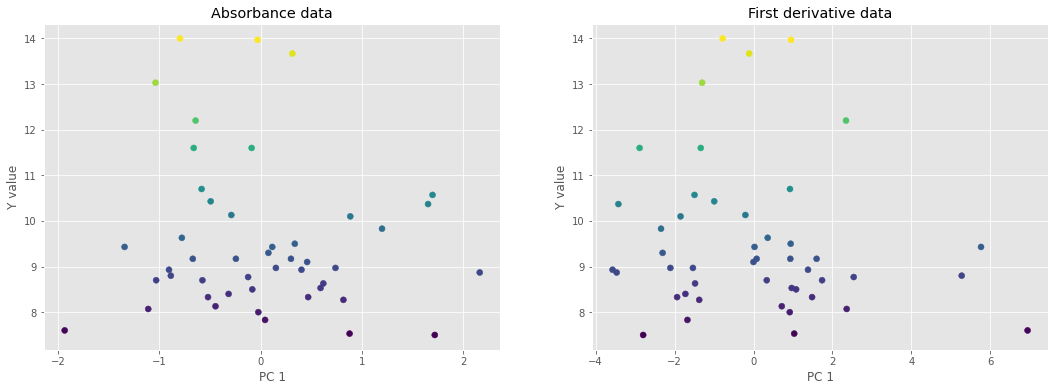

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

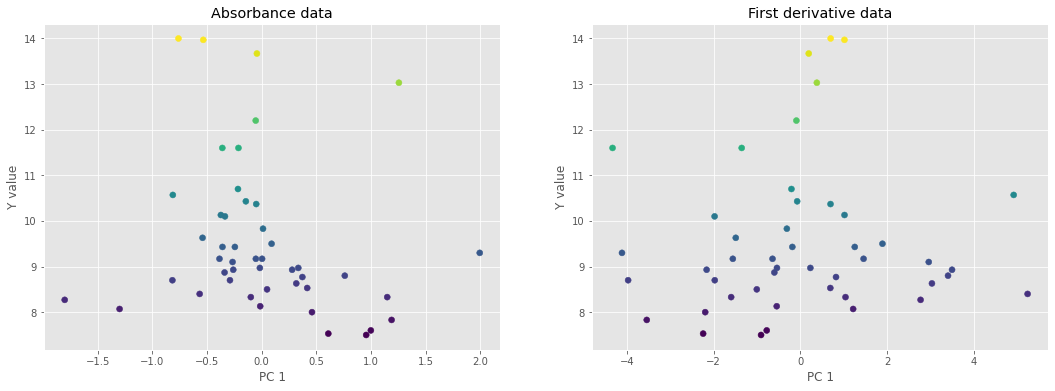

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

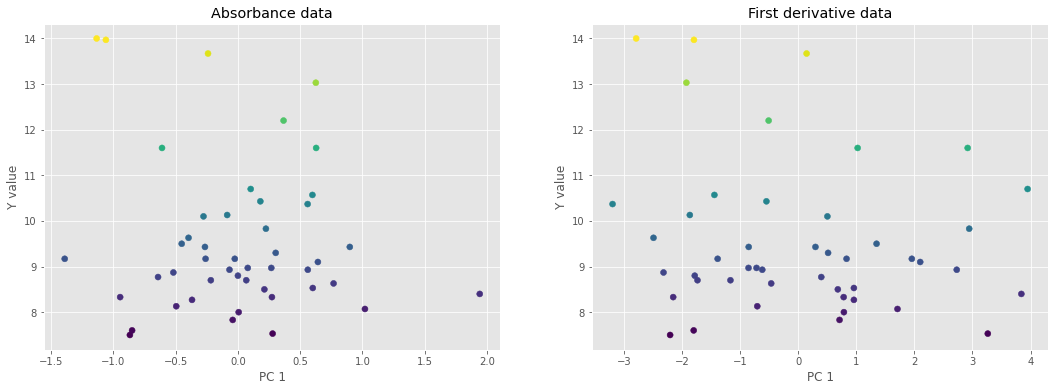

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

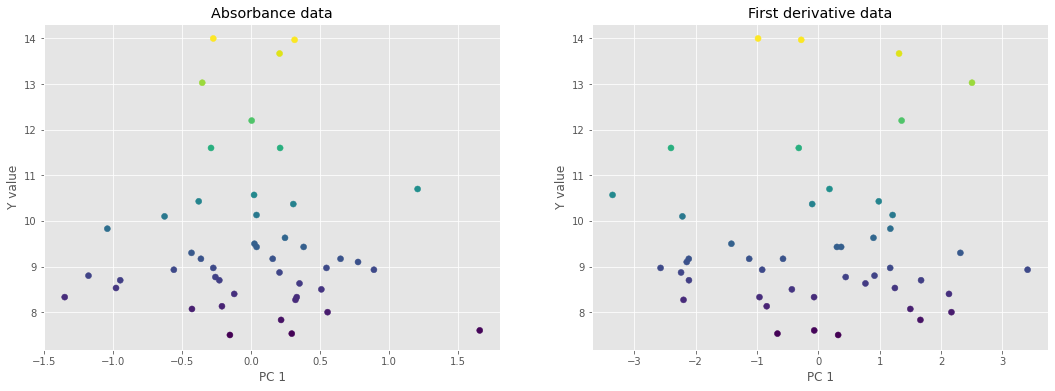

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

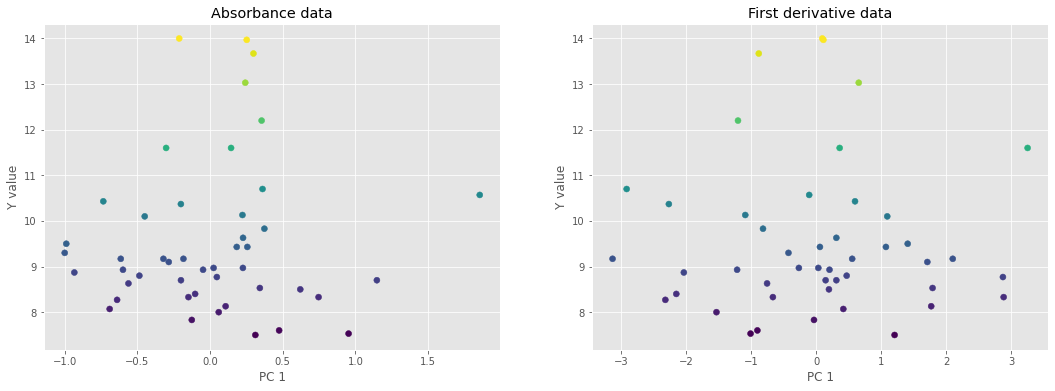

<IPython.core.display.Javascript object>

In [ ]:
skpca1 = sk_pca(n_components = 10)
skpca2 = sk_pca(n_components = 10)
X1 = skpca1.fit(nfeat1right)
X2 = skpca2.fit(nfeat2right)
fit1= X1.fit_transform(nfeat1right)
fit2= X2.fit_transform(nfeat2right)
tb = widgets.TabBar([str(i) for i in range(10)])
for i in range(10):
    with tb.output_to(i, select=(i < 3)):
        with plt.style.context('ggplot'):
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
            fig.set_tight_layout(False)
            
            ax1.scatter(np.transpose(fit1)[i],Yright,c=Yright)
            ax1.set_xlabel("PC 1")
            ax1.set_ylabel("Y value")
            ax2.scatter(np.transpose(fit2)[i],Yright,c=Yright)
            ax2.set_xlabel("PC 1")
            ax2.set_ylabel("Y value")
            ax1.set_title("Absorbance data")
            ax2.set_title("First derivative data")

#O-PLS method

Another processing method that we will try is Orthoganal-Partial Least Square (O-PLS). This method is similar to PLS by that it projects Dependent variable on to the Independent variable and find latent variables that correlates to the Dependent variable. O-PLS took a step furthe and at Orthogonal Signal Correction (OSC) to remove Orthogonal variables.

In this case, we will limit the amount of latent variables to 5 and plot each of them to a graph and see if there are correlations between them and Y.

<strong>Metrics being used to measure accuracy.</strong>

In order to tell how accurate the model is, we must use a metric to measure the accuracy of the model. Here we will use multiple metrics to determine how accurate the model is and what type of accuracy are we looking for in this situation.

Here are the metrics being used:
 - <strong>R-squared</strong>: the proportion of the variance in the dependent variable that is predictable from the independent variable(s). It provides a measure of how well observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model. The drawbacks of this metric is it does not tell  whether or not the estimate is biased.
 - <strong>Mean Squared Error (MSE)</strong>: the average squared difference between the estimated values and the actual value. The smaller the means squared error, the closer you are to finding the line of best fit.This is one of the most used metrics in statistic.
 - <strong>Root Mean Squared Error (RMSE)</strong>: the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. 
 - <strong>Mean Absolute Error (MAE)</strong>: measures the average magnitude of the errors in a set of forecasts, without considering their direction.
 - <strong>Mean Absolute Percentage Error (MAPE)</strong>: a statistical measure of how accurate a forecast system is. It measures this accuracy as a percentage, and works best if there are no extremes to the data (and no zeros).


In [ ]:
### setting the O-PLS structure, fit the data into it and transform it.

opls_gen_X =  OPLS()
opls_gen_dX =  OPLS()
opls_gen_X = opls_gen_X.fit(X,Y)
opls_gen_dX = opls_gen_dX.fit(dX,Y)
X_opls = opls_gen_X.transform(X)
dX_opls = opls_gen_dX.transform(dX)

### print out the scores, the definition and what it does is explained in the class

print(opls_gen_X.score(X))
print(opls_gen_dX.score(dX))

2.772481015315209e-09
2.1808087582878033e-06


In [ ]:
fit1.shape

(46, 10)

R^2 of the normal data is 0.9472188796329214
R^2 of the derivative 1 data is 0.4746587964135642
MSE of the normal data is 0.142525001506989
MSE of the derivative 1 data is 1.418580267188526
RMSE of the normal data is 0.377524835616134
RMSE of the derivative 1 data is 1.1910416731535995
MAE of the normal data is 0.30756444449629866
MAE of the derivative 1 data is 0.9097418068221567
MAPE of the normal data is 0.15185677109937296
MAPE of the derivative 1 data is 0.1262524613537309
(2, 92)


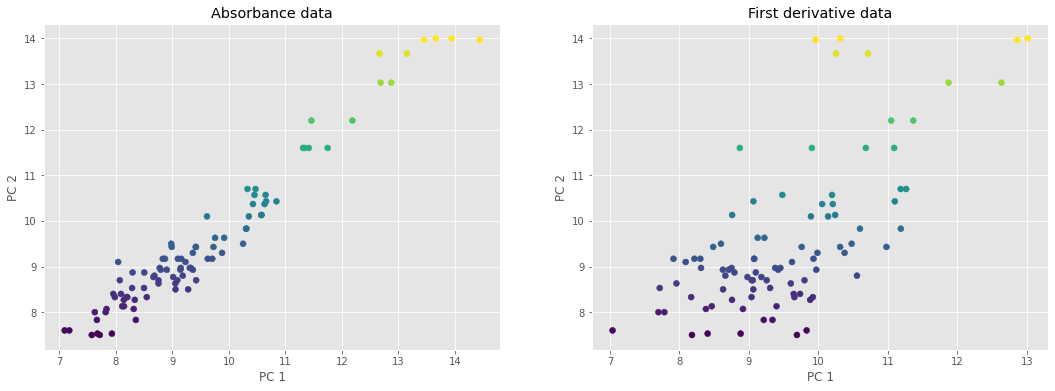

In [ ]:
fit1og = X_opls
fit2og = dX_opls
### we are now going to apply PLS after O-PLS since this 
### OPLS model only removes orthoganal variables and not truly O-PLS
plsX = PLS()
plsdX = PLS()

plsX.fit(fit1og,Y)
plsdX.fit(fit2og,Y)

fit1 = plsX.transform(fit1og)
fit2 = plsdX.transform(fit1og)
linearfit1 =LinearRegression()
linearfit2 = LinearRegression()

linearfit1.fit(fit1,Y)
linearfit2.fit(fit2,Y)

Ypred=linearfit1.predict(fit1)
dYpred=linearfit2.predict(fit2)
print("R^2 of the normal data is "+str(polyfit(Ypred,Y)))
print("R^2 of the derivative 1 data is "+str(polyfit(dYpred,Y)))

print("MSE of the normal data is "+str(mean_squared_error(Ypred,Y)))
print("MSE of the derivative 1 data is "+str(mean_squared_error(dYpred,Y)))

print("RMSE of the normal data is "+str(sqrt(mean_squared_error(Ypred,Y))))
print("RMSE of the derivative 1 data is "+str(sqrt(mean_squared_error(dYpred,Y))))

print("MAE of the normal data is "+str(mean_absolute_error(Ypred,Y)))
print("MAE of the derivative 1 data is "+str(mean_absolute_error(dYpred,Y)))

print("MAPE of the normal data is "+str(mean_absolute_percentage_error(Ypred,Y)))
print("MAPE of the derivative 1 data is "+str(mean_absolute_percentage_error(dYpred,Y)))



with plt.style.context('ggplot'):
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
      fig.set_tight_layout(False)
      print(fit1.T.shape)
      CS=ax1.scatter(Ypred,Y,c=Y)
      ax1.set_xlabel("PC 1")
      ax1.set_ylabel("PC 2")
      CS2=ax2.scatter(dYpred,Y,c=Y)
      ax2.set_xlabel("PC 1")
      ax2.set_ylabel("PC 2")
      ax1.set_title("Absorbance data")
      ax2.set_title("First derivative data")
      plt.show()

<strong> O-PLS on different sides</strong>

Next, we will then apply the same method to the left and right side of the mango spectra.

In [ ]:
X_opls.shape

(92, 227)

R^2 of the normal data is 0.9963376597578713
R^2 of the derivative 1 data is 0.9626618067025697
MSE of the normal data is 0.00988942722129261
MSE of the derivative 1 data is 0.1008244239412502
RMSE of the normal data is 0.09944559930581448
RMSE of the derivative 1 data is 0.3175286190900754
MAE of the normal data is 0.08050358028986337
MAE of the derivative 1 data is 0.25308458800078926
MAPE of the normal data is 0.00850686288731808
MAPE of the derivative 1 data is 0.02684010187665706


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(2, 46)


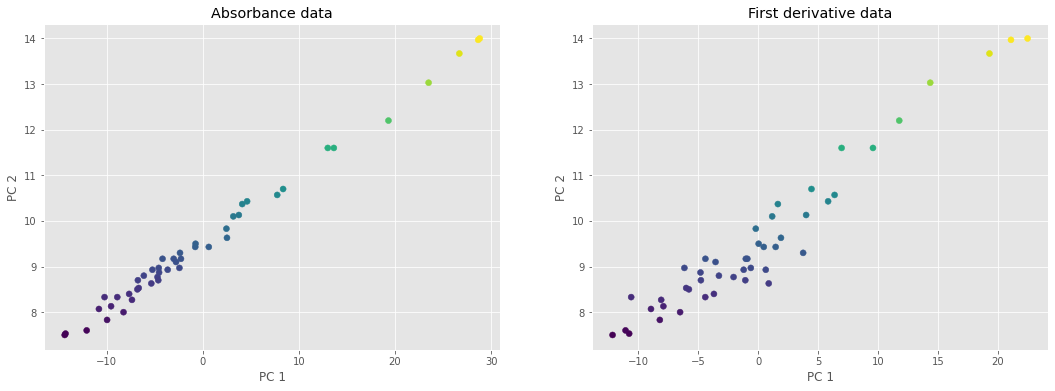

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(2, 46)


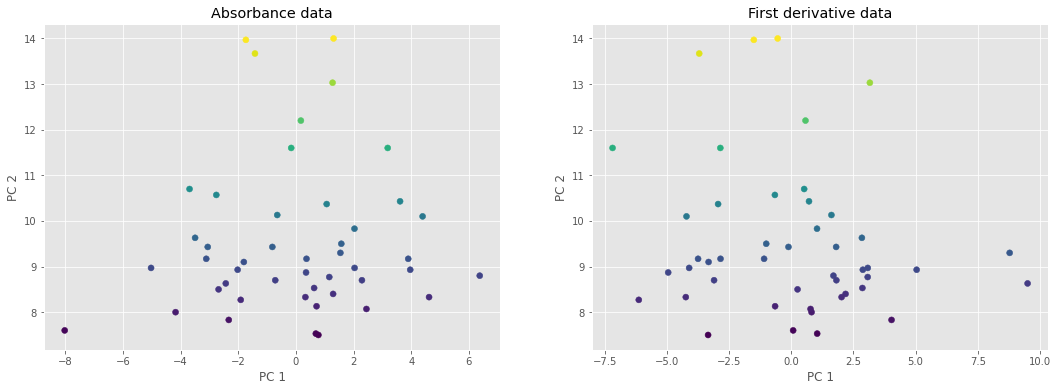

<IPython.core.display.Javascript object>

In [ ]:
### setting the O-PLS structure, fit the data into it and transform it.
### plot data for the right side
opls_gen_Xright =  OPLS(scale=True)
opls_gen_dXright =  OPLS()
opls_gen_Xright = opls_gen_Xright.fit(Xright,Yright)
opls_gen_dXright = opls_gen_dXright.fit(dXright,Yright)
X_opls = opls_gen_Xright.transform(Xright)
dX_opls = opls_gen_dXright.transform(dXright)

fit1og = X_opls
fit2og = dX_opls

### we are now going to apply PLS after O-PLS since this 
### OPLS model only removes orthoganal variables and not truly O-PLS
plsX = PLS()
plsdX = PLS()

plsX.fit(fit1og,Yright)
plsdX.fit(fit2og,Yright)

print("R^2 of the normal data is "+str(plsX.score(fit1og,Yright)))
print("R^2 of the derivative 1 data is "+str(plsdX.score(fit2og,Yright)))

Ypred=plsX.predict(fit1og)
dYpred=plsdX.predict(fit2og)
print("MSE of the normal data is "+str(mean_squared_error(Ypred,Yright)))
print("MSE of the derivative 1 data is "+str(mean_squared_error(dYpred,Yright)))
print("RMSE of the normal data is "+str(sqrt(mean_squared_error(Ypred,Yright))))
print("RMSE of the derivative 1 data is "+str(sqrt(mean_squared_error(dYpred,Yright))))

print("MAE of the normal data is "+str(mean_absolute_error(Ypred,Yright)))
print("MAE of the derivative 1 data is "+str(mean_absolute_error(dYpred,Yright)))

print("MAPE of the normal data is "+str(mean_absolute_percentage_error(Ypred,Yright)))
print("MAPE of the derivative 1 data is "+str(mean_absolute_percentage_error(dYpred,Yright)))
fit1 = plsX.transform(fit1og)
fit2 = plsdX.transform(fit2og)

tb = widgets.TabBar([str(i) for i in range(2)])
for i in range(2):
    with tb.output_to(i, select=(i < 3)):
        with plt.style.context('ggplot'):
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
            fig.set_tight_layout(False)
            print(fit1.T.shape)
            CS = ax1.scatter(np.transpose(fit1)[i],Yright,c=Yright)
            ax1.set_xlabel("PC 1")
            ax1.set_ylabel("PC 2")
            CS2=ax2.scatter(np.transpose(fit2)[i],Yright,c=Yright)
            ax2.set_xlabel("PC 1")
            ax2.set_ylabel("PC 2")
            ax1.set_title("Absorbance data")
            ax2.set_title("First derivative data")
            plt.show()

R^2 of the normal data is 0.9948272613371069
R^2 of the derivative 1 data is 0.9658175628653971
RMSE of the normal data is 0.11818612501277896
RMSE of the derivative 1 data is 0.3038139678716437
MSE of the normal data is 0.013967960145536218
MSE of the derivative 1 data is 0.09230292707391216
MAE of the normal data is 0.09526871382947456
MAE of the derivative 1 data is 0.25351071217944116
MAPE of the normal data is 0.010078236808459077
MAPE of the derivative 1 data is 0.026653514880978172


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

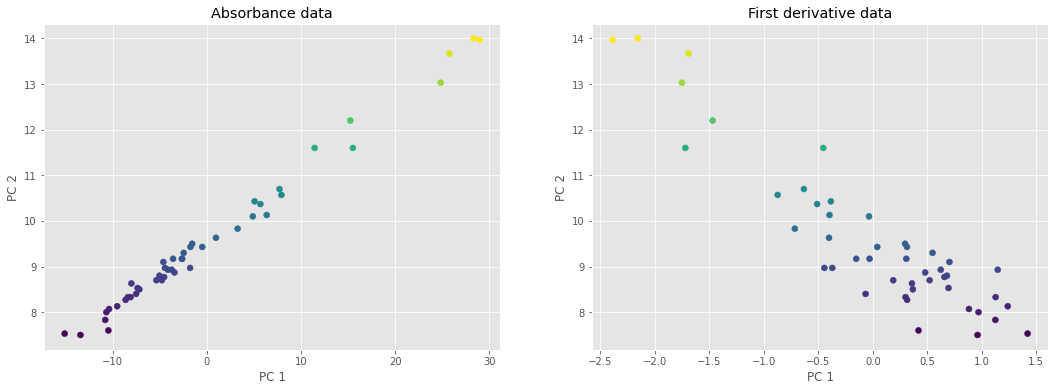

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

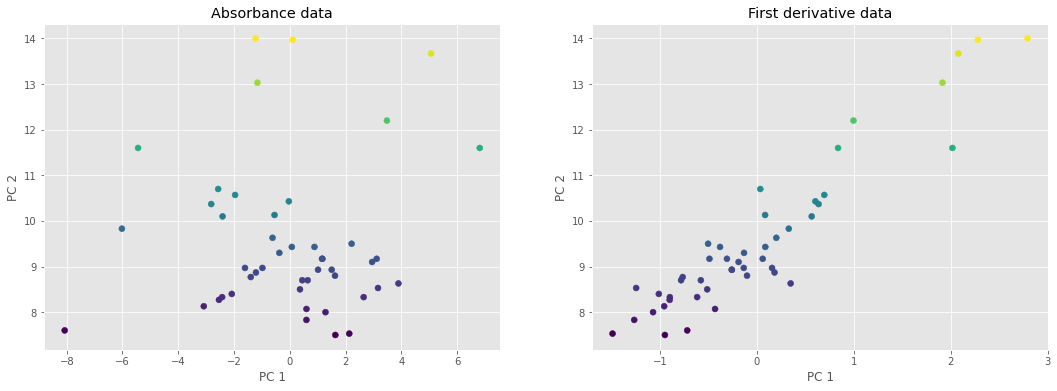

<IPython.core.display.Javascript object>

In [ ]:
### setting the O-PLS structure, fit the data into it and transform it.
### plot data for the right side
opls_gen_Xleft =  OPLS(scale=True)
opls_gen_dXleft =  OPLS()
opls_gen_Xleft = opls_gen_Xleft.fit(Xleft,Yleft)
opls_gen_dXleft = opls_gen_dXleft.fit(dXleft,Yleft)
X_opls = opls_gen_Xleft.transform(Xleft)
dX_opls = opls_gen_dXleft.transform(dXleft)

fit1og = X_opls
fit2og = dX_opls

### we are now going to apply PLS after O-PLS since this 
### OPLS model only removes orthoganal variables and not truly O-PLS
plsX = PLS()
plsdX = PLS()

plsX.fit(fit1og,Yleft)
plsdX.fit(fit2og,Yleft)
Ypred=plsX.predict(fit1og)
dYpred=plsdX.predict(fit2og)
print("R^2 of the normal data is "+str(plsX.score(fit1og,Yleft)))
print("R^2 of the derivative 1 data is "+str(plsdX.score(fit2og,Yleft)))

print("RMSE of the normal data is "+str(sqrt(mean_squared_error(Ypred,Yleft))))
print("RMSE of the derivative 1 data is "+str(sqrt(mean_squared_error(dYpred,Yleft))))


print("MSE of the normal data is "+str(mean_squared_error(Ypred,Yleft)))
print("MSE of the derivative 1 data is "+str(mean_squared_error(dYpred,Yleft)))


print("MAE of the normal data is "+str(mean_absolute_error(Ypred,Yleft)))
print("MAE of the derivative 1 data is "+str(mean_absolute_error(dYpred,Yleft)))

print("MAPE of the normal data is "+str(mean_absolute_percentage_error(Ypred,Yleft)))
print("MAPE of the derivative 1 data is "+str(mean_absolute_percentage_error(dYpred,Yleft)))
fit1 = plsX.transform(fit1og)
fit2 = plsdX.transform(fit1og)

tb = widgets.TabBar([str(i) for i in range(2)])
for i in range(2):
    with tb.output_to(i, select=(i < 3)):
        with plt.style.context('ggplot'):
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
            fig.set_tight_layout(False)
            CS = ax1.scatter(np.transpose(fit1)[i],Yleft,c=Yleft)
            ax1.set_xlabel("PC 1")
            ax1.set_ylabel("PC 2")
            CS2=ax2.scatter(np.transpose(fit2)[i],Yleft,c=Yleft)
            ax2.set_xlabel("PC 1")
            ax2.set_ylabel("PC 2")
            ax1.set_title("Absorbance data")
            ax2.set_title("First derivative data")
            plt.show()

In [ ]:
X_opls.shape

(46, 227)

#Mean centering

One of the easier methods to find a suitable variable from all of the variables is to graph each indiviual variables on a plot after Mean centering. This step will enphasize the difference between variables in difference observations and hopefully will give us more information on the data.

We first mean centering the data using standScaler() without standard diviation.

In [ ]:
nfeat1mean = standardScaler(with_std = False).fit_transform(X)
nfeat2mean = standardScaler(with_std = False).fit_transform(dX)

(92, 227)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

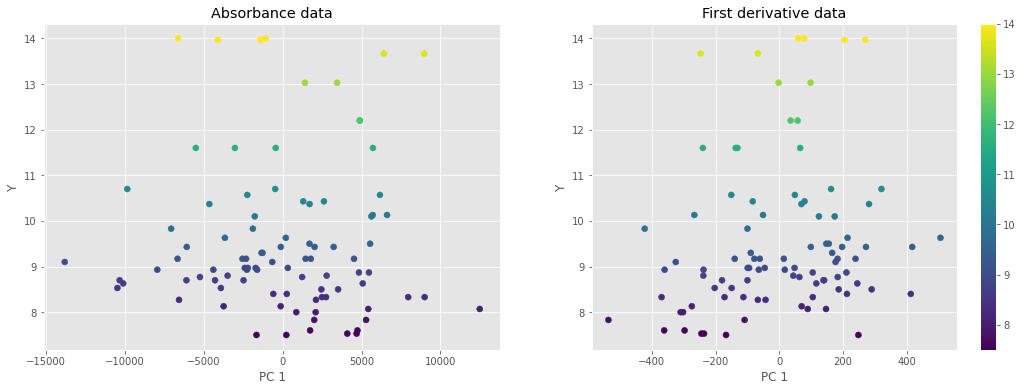

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

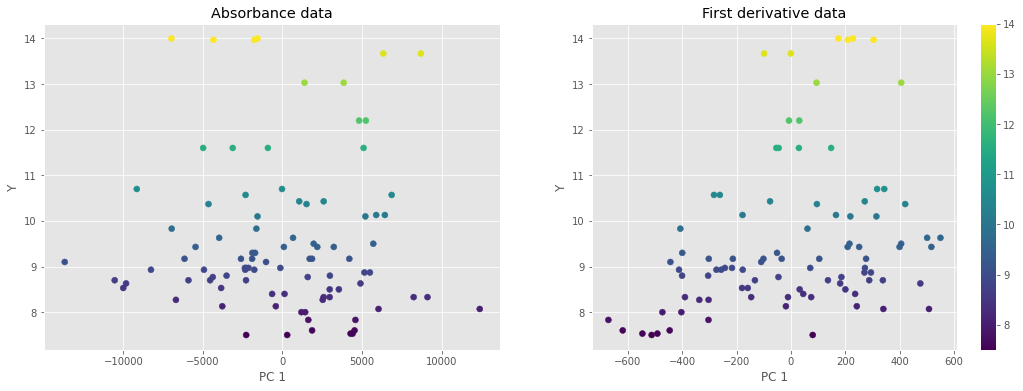

<IPython.core.display.Javascript object>

In [ ]:
fit1= nfeat1mean
fit2= nfeat2mean
print(fit1.shape)

tb = widgets.TabBar([str(i) for i in range(2)])
for i in range(2):
    with tb.output_to(i, select=(i < 3)):
        with plt.style.context('ggplot'):
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
            fig.set_tight_layout(False)
            
            CS=ax1.scatter(np.transpose(fit1)[i],Y,c=Y)
            ax1.set_xlabel("PC 1")
            ax1.set_ylabel("Y")
            CS2=ax2.scatter(np.transpose(fit2)[i],Y,c=Y)
            ax2.set_xlabel("PC 1")
            ax2.set_ylabel("Y")
            ax1.set_title("Absorbance data")
            ax2.set_title("First derivative data")


            fig.colorbar(CS)
            plt.show()

#NOTES !!!:

-Date: 30-10-2020

After trying to analyze the spectra other Dependent variable, I have notices a few noticable behavior:
 - The dataset is lacking samples that have higher Dependent variables (promenent in almost all four of the Dependent varialbes).
 - Some of the data fitted extra well when it comes to fitting only one side of the spectra (promenent in the acidity).

Some suggestions for the future:
 - Adding more spectra of samples that has higher sugar content (typically lower acid content).
 - Only measure one side of the mango that is better at fitting into datas.

-Date: 31-10-2020

There are correlations between Dry matter and the ripeness of the mango. There are also devices that detects Dry matter percentage with little errors. These two discoveries have helped people to classify the quality and ripeness of the mango. We can try to find their approach to improve our performance and possibly building one ourselves.

-Date: 01-11-2020

There is a chance for the data to be overfitted, which will cause issues in the long run. One of the solutions is to create random samples from the dataset which, is a good idea, overall will not tell us whether or not the model is over fit. More the data is a better option.


#Behavior Notes:
-date: 30-10-2020

After using O-PLS on the Independent variables in conjunction with other Dependent variables, there is a small behavior i have observed:
- The trends between fitting X using O-PLS with Sugar content is the opposite of fitting X with Acid content, which is similar in real life ( when mango gets ripen, the sweeter it gets and the less sour it taste ) 
- The raise of the Sugar content also correlates to the raise of the Dry matter contents, since the riper the mango is, the more dry matter it has.

-date: 01-11-2020

After applying MSC to the dataset, it seems that it was not reall effective:
- The opls graph on the normal data was not as uniformed as before. However the derivative works in some situation, all be it not too well.
- The opls scores is lower compare to before performing MSC on the data by a slight margin, although it is not useful since the data is way too scewed.

#Next Objective:

- Add some metric to determine how good the method sums up the dataset.
- Testing different spectra dataset in different regions to see determine which region should be scanned for data.
- Looking into risks about overfiting the result in those methods.
- Adding and testing the effectiveness of MSC ( Multivariative scatter correction ) (checked)

#Testing the model 

After trying to use a few methods that is common in the NIR spectra analysis field, O-PLS was chosen to be the preferred method with the Savitzky-Golay filter with first derivative preprocessing technic as another option before normalizing the data and fit it to the model.

We are now going to test it using the same dataset but we will let the model look at 70% of the data and let it predict the other 30% to see if it is correct or not.

<strong>Edit:</strong> this section has now turned into a collection of preprocessing methods to compare each other, using linear regression as a base model

In [ ]:
X_train, X_test, Y_train, Y_test  = train_test_split(X,Y,test_size = 0.3,random_state = 1)
dX_train, dX_test, dY_train, dY_test  = train_test_split(dX,Y,test_size = 0.3,random_state = 1)
opls_gen_X_test =  OPLS(n_components=10)
opls_gen_dX_test =  OPLS(n_components=10)
opls_gen_X_test = opls_gen_X_test.fit(X_train,Y_train)
opls_gen_dX_test = opls_gen_dX_test.fit(dX_train,dY_train)
X_opls_test = opls_gen_X_test.transform(X_train)
dX_opls_test = opls_gen_dX_test.transform(dX_train)


R^2 of the normal data is 0.9770125457500443
R^2 of the derivative 1 data is 0.8432430272056519
MSE of the normal data is 0.059678033035567596
MSE of the derivative 1 data is 0.40695884369165086
RMSE of the normal data is 0.24429087792131657
RMSE of the derivative 1 data is 0.6379332595904142
MAE of the normal data is 0.19841337354118088
MAE of the derivative 1 data is 0.4965251520831625
MAPE of the normal data is 0.12891065834361626
MAPE of the derivative 1 data is 0.13236369826819464
(2, 64)


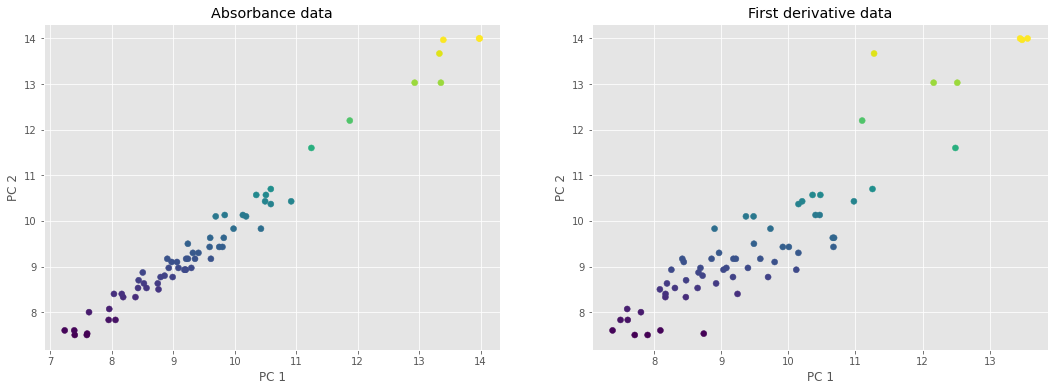

In [ ]:
fit1og = X_opls_test
fit2og = dX_opls_test

### we are now going to apply PLS after O-PLS since this 
### OPLS model only removes orthoganal variables and not truly O-PLS
plsX = PLS()
plsdX = PLS()

plsX.fit(fit1og,Y_train)
plsdX.fit(fit2og,dY_train)
fit1 = plsX.transform(fit1og)
fit2 = plsdX.transform(fit2og)
linearfit1 =LinearRegression()
linearfit2 = LinearRegression()

linearfit1.fit(fit1,Y_train)
linearfit2.fit(fit2,dY_train)

Ypred=linearfit1.predict(fit1)
dYpred=linearfit2.predict(fit2)
print("R^2 of the normal data is "+str(polyfit(Ypred,Y_train)))
print("R^2 of the derivative 1 data is "+str(polyfit(dYpred,dY_train)))

print("MSE of the normal data is "+str(mean_squared_error(Ypred,Y_train)))
print("MSE of the derivative 1 data is "+str(mean_squared_error(dYpred,dY_train)))

print("RMSE of the normal data is "+str(sqrt(mean_squared_error(Ypred,Y_train))))
print("RMSE of the derivative 1 data is "+str(sqrt(mean_squared_error(dYpred,dY_train))))

print("MAE of the normal data is "+str(mean_absolute_error(Ypred,Y_train)))
print("MAE of the derivative 1 data is "+str(mean_absolute_error(dYpred,dY_train)))

print("MAPE of the normal data is "+str(mean_absolute_percentage_error(Ypred,Y_train)))
print("MAPE of the derivative 1 data is "+str(mean_absolute_percentage_error(dYpred,dY_train)))



with plt.style.context('ggplot'):
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
      fig.set_tight_layout(False)
      print(fit1.T.shape)
      CS=ax1.scatter(Ypred,Y_train,c=Y_train)
      ax1.set_xlabel("PC 1")
      ax1.set_ylabel("PC 2")
      CS2=ax2.scatter(dYpred,dY_train,c=dY_train)
      ax2.set_xlabel("PC 1")
      ax2.set_ylabel("PC 2")
      ax1.set_title("Absorbance data")
      ax2.set_title("First derivative data")
      plt.show()

R^2 of the normal data is 0.49999496933679927
R^2 of the derivative 1 data is 0.3398425402020549
MSE of the normal data is 1.4700580357030477
MSE of the derivative 1 data is 7.692778409344973
RMSE of the normal data is 1.2124594985825496
RMSE of the derivative 1 data is 2.773585839548683
MAE of the normal data is 0.9595267432684101
MAE of the derivative 1 data is 2.230304604683216
MAPE of the normal data is 0.16137999610782203
MAPE of the derivative 1 data is 0.19368514781925453
(2, 28)


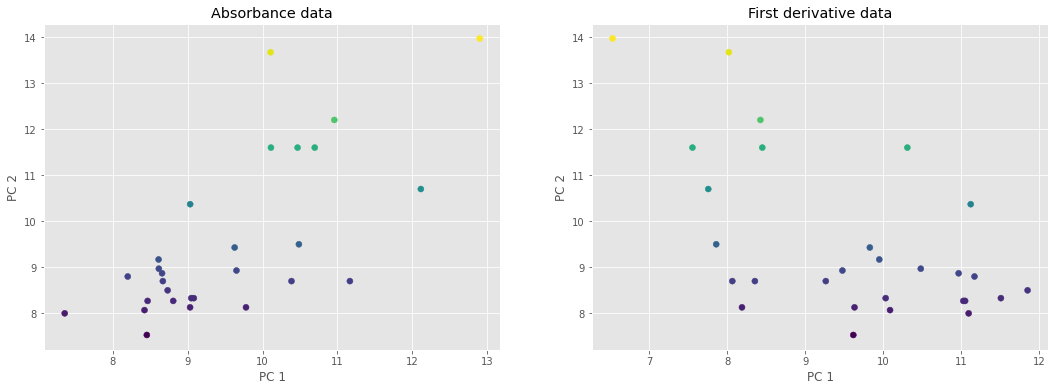

In [ ]:
X_opls_test = opls_gen_X_test.transform(X_test)
dX_opls_test = opls_gen_dX_test.transform(dX_test)

fit1og = X_opls_test
fit2og = dX_opls_test
plsX.fit(fit1og,Y_test)
plsdX.fit(fit2og,dY_test)
fit1 = plsX.transform(fit1og)
fit2 = plsdX.transform(fit2og)
Ypred=linearfit1.predict(fit1)
dYpred=linearfit2.predict(fit2)
### we are now going to apply PLS after O-PLS since this 
### OPLS model only removes orthoganal variables and not truly O-PLS

print("R^2 of the normal data is "+str(polyfit(Ypred,Y_test)))
print("R^2 of the derivative 1 data is "+str(polyfit(dYpred,dY_test)))

print("MSE of the normal data is "+str(mean_squared_error(Ypred,Y_test)))
print("MSE of the derivative 1 data is "+str(mean_squared_error(dYpred,dY_test)))

print("RMSE of the normal data is "+str(sqrt(mean_squared_error(Ypred,Y_test))))
print("RMSE of the derivative 1 data is "+str(sqrt(mean_squared_error(dYpred,dY_test))))

print("MAE of the normal data is "+str(mean_absolute_error(Ypred,Y_test)))
print("MAE of the derivative 1 data is "+str(mean_absolute_error(dYpred,dY_test)))

print("MAPE of the normal data is "+str(mean_absolute_percentage_error(Ypred,Y_test)))
print("MAPE of the derivative 1 data is "+str(mean_absolute_percentage_error(dYpred,dY_test)))



with plt.style.context('ggplot'):
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
      fig.set_tight_layout(False)
      print(fit1.T.shape)
      CS=ax1.scatter(Ypred,Y_test,c=Y_test)
      ax1.set_xlabel("PC 1")
      ax1.set_ylabel("PC 2")
      CS2=ax2.scatter(dYpred,dY_test,c=dY_test)
      ax2.set_xlabel("PC 1")
      ax2.set_ylabel("PC 2")
      ax1.set_title("Absorbance data")
      ax2.set_title("First derivative data")
      plt.show()

<strong>PCA test</strong>

R^2 of the normal data is 0.4021188624662478
R^2 of the derivative 1 data is 0.3451872434976198
MSE of the normal data is 1.5521671033734017
MSE of the derivative 1 data is 1.6999680299411928
RMSE of the normal data is 1.245859985461208
RMSE of the derivative 1 data is 1.303828221024991
MAE of the normal data is 1.0064545979404245
MAE of the derivative 1 data is 0.9902305099686768
MAPE of the normal data is 0.13132926718773386
MAPE of the derivative 1 data is 0.13870111249152237
(10, 64)


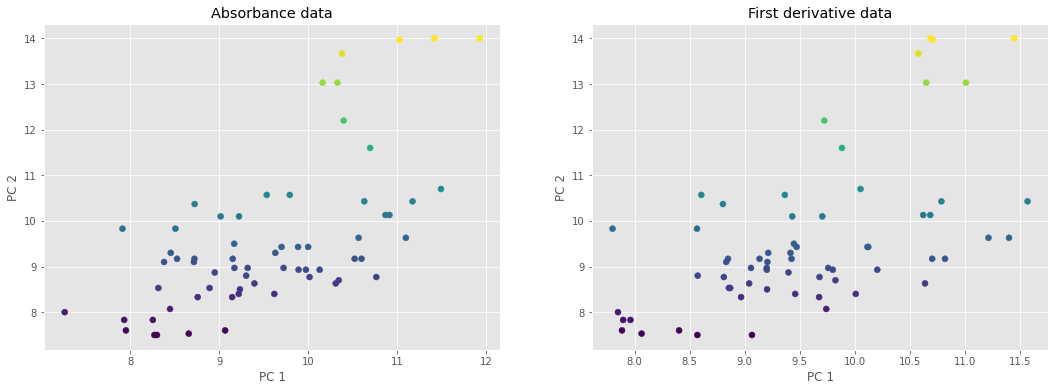

In [ ]:
### Initialise
skpca1 = sk_pca(n_components = 10)
skpca2 = sk_pca(n_components = 10)

### Standardized the data
### This is important when correlating data with very different variances
nfeat1 = standardScaler().fit_transform(X_train)
nfeat2 = standardScaler().fit_transform(dX_train)

X1 = skpca1.fit(nfeat1)
X2 = skpca2.fit(nfeat2)
fit1= X1.fit_transform(nfeat1)
fit2= X2.fit_transform(nfeat2)
linearfit1 =LinearRegression()
linearfit2 = LinearRegression()

linearfit1.fit(fit1,Y_train)
linearfit2.fit(fit2,dY_train)

Ypred=linearfit1.predict(fit1)
dYpred=linearfit2.predict(fit2)
print("R^2 of the normal data is "+str(polyfit(Ypred,Y_train)))
print("R^2 of the derivative 1 data is "+str(polyfit(dYpred,dY_train)))

print("MSE of the normal data is "+str(mean_squared_error(Ypred,Y_train)))
print("MSE of the derivative 1 data is "+str(mean_squared_error(dYpred,dY_train)))

print("RMSE of the normal data is "+str(sqrt(mean_squared_error(Ypred,Y_train))))
print("RMSE of the derivative 1 data is "+str(sqrt(mean_squared_error(dYpred,dY_train))))

print("MAE of the normal data is "+str(mean_absolute_error(Ypred,Y_train)))
print("MAE of the derivative 1 data is "+str(mean_absolute_error(dYpred,dY_train)))

print("MAPE of the normal data is "+str(mean_absolute_percentage_error(Ypred,Y_train)))
print("MAPE of the derivative 1 data is "+str(mean_absolute_percentage_error(dYpred,dY_train)))



with plt.style.context('ggplot'):
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
      fig.set_tight_layout(False)
      print(fit1.T.shape)
      CS=ax1.scatter(Ypred,Y_train,c=Y_train)
      ax1.set_xlabel("PC 1")
      ax1.set_ylabel("PC 2")
      CS2=ax2.scatter(dYpred,dY_train,c=dY_train)
      ax2.set_xlabel("PC 1")
      ax2.set_ylabel("PC 2")
      ax1.set_title("Absorbance data")
      ax2.set_title("First derivative data")
      plt.show()

R^2 of the normal data is 0.32972954294651075
R^2 of the derivative 1 data is 0.33167684857735447
MSE of the normal data is 1.9789139705006324
MSE of the derivative 1 data is 1.9647083534627399
RMSE of the normal data is 1.4067387712367327
RMSE of the derivative 1 data is 1.4016805461526316
MAE of the normal data is 1.1298106727426416
MAE of the derivative 1 data is 1.1143930986724568
MAPE of the normal data is 0.17212201704843588
MAPE of the derivative 1 data is 0.16106987273755774
(10, 28)


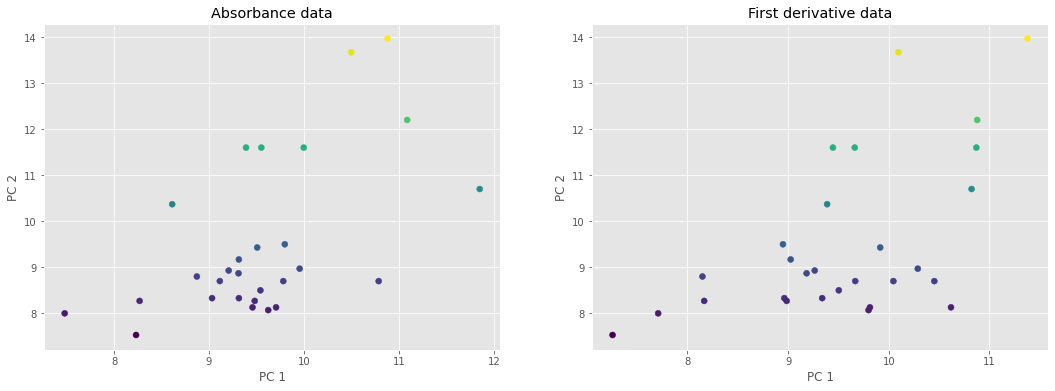

In [ ]:
nfeat1 = standardScaler().fit_transform(X_test)
nfeat2 = standardScaler().fit_transform(dX_test)

fit1= X1.transform(nfeat1)
fit2= X2.transform(nfeat2)

Ypred=linearfit1.predict(fit1)
dYpred=linearfit2.predict(fit2)

print("R^2 of the normal data is "+str(polyfit(Ypred,Y_test)))
print("R^2 of the derivative 1 data is "+str(polyfit(dYpred,dY_test)))

print("MSE of the normal data is "+str(mean_squared_error(Ypred,Y_test)))
print("MSE of the derivative 1 data is "+str(mean_squared_error(dYpred,dY_test)))

print("RMSE of the normal data is "+str(sqrt(mean_squared_error(Ypred,Y_test))))
print("RMSE of the derivative 1 data is "+str(sqrt(mean_squared_error(dYpred,dY_test))))

print("MAE of the normal data is "+str(mean_absolute_error(Ypred,Y_test)))
print("MAE of the derivative 1 data is "+str(mean_absolute_error(dYpred,dY_test)))

print("MAPE of the normal data is "+str(mean_absolute_percentage_error(Ypred,Y_test)))
print("MAPE of the derivative 1 data is "+str(mean_absolute_percentage_error(dYpred,dY_test)))



with plt.style.context('ggplot'):
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
      fig.set_tight_layout(False)
      print(fit1.T.shape)
      CS=ax1.scatter(Ypred,Y_test,c=Y_test)
      ax1.set_xlabel("PC 1")
      ax1.set_ylabel("PC 2")
      CS2=ax2.scatter(dYpred,dY_test,c=dY_test)
      ax2.set_xlabel("PC 1")
      ax2.set_ylabel("PC 2")
      ax1.set_title("Absorbance data")
      ax2.set_title("First derivative data")
      plt.show()

<strong> PLS model</strong>

R^2 of the normal data is 0.10895158161889996
R^2 of the derivative 1 data is 0.25252655867479334
MSE of the normal data is 2.313262546179533
MSE of the derivative 1 data is 1.9405256554105577
RMSE of the normal data is 1.5209413355483286
RMSE of the derivative 1 data is 1.3930275142331388
MAE of the normal data is 1.0976438430550406
MAE of the derivative 1 data is 1.0453107910222736
MAPE of the normal data is 0.12865003247394702
MAPE of the derivative 1 data is 0.1381246214872123
(2, 64)


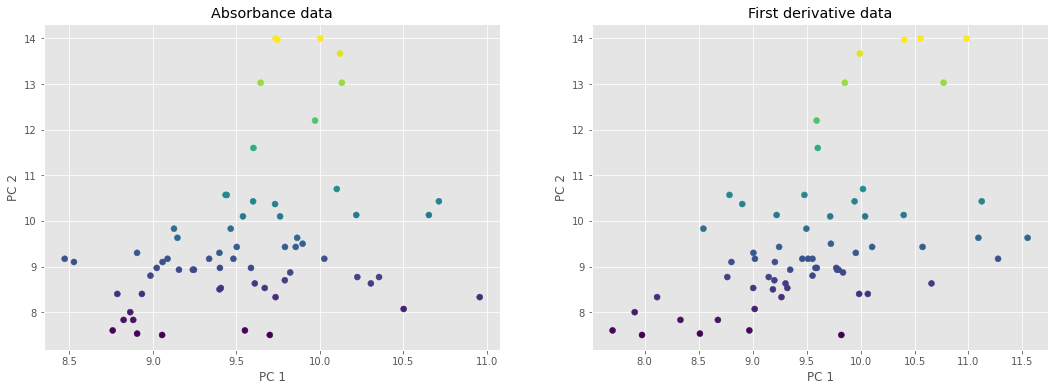

In [ ]:
plsX = PLS()
plsdX = PLS()

plsX.fit(X_train,Y_train)
plsdX.fit(dX_train,dY_train)

fit1= plsX.transform(X_train)
fit2= plsX.transform(dX_train)
linearfit1 =LinearRegression()
linearfit2 = LinearRegression()

linearfit1.fit(fit1,Y_train)
linearfit2.fit(fit2,dY_train)

Ypred=linearfit1.predict(fit1)
dYpred=linearfit2.predict(fit2)
print("R^2 of the normal data is "+str(polyfit(Ypred,Y_train)))
print("R^2 of the derivative 1 data is "+str(polyfit(dYpred,dY_train)))

print("MSE of the normal data is "+str(mean_squared_error(Ypred,Y_train)))
print("MSE of the derivative 1 data is "+str(mean_squared_error(dYpred,dY_train)))

print("RMSE of the normal data is "+str(sqrt(mean_squared_error(Ypred,Y_train))))
print("RMSE of the derivative 1 data is "+str(sqrt(mean_squared_error(dYpred,dY_train))))

print("MAE of the normal data is "+str(mean_absolute_error(Ypred,Y_train)))
print("MAE of the derivative 1 data is "+str(mean_absolute_error(dYpred,dY_train)))

print("MAPE of the normal data is "+str(mean_absolute_percentage_error(Ypred,Y_train)))
print("MAPE of the derivative 1 data is "+str(mean_absolute_percentage_error(dYpred,dY_train)))



with plt.style.context('ggplot'):
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
      fig.set_tight_layout(False)
      print(fit1.T.shape)
      CS=ax1.scatter(Ypred,Y_train,c=Y_train)
      ax1.set_xlabel("PC 1")
      ax1.set_ylabel("PC 2")
      CS2=ax2.scatter(dYpred,dY_train,c=dY_train)
      ax2.set_xlabel("PC 1")
      ax2.set_ylabel("PC 2")
      ax1.set_title("Absorbance data")
      ax2.set_title("First derivative data")
      plt.show()

R^2 of the normal data is 0.1250113358656663
R^2 of the derivative 1 data is 0.17418704854343825
MSE of the normal data is 2.5944377185461294
MSE of the derivative 1 data is 2.4613694580098056
RMSE of the normal data is 1.6107258359342627
RMSE of the derivative 1 data is 1.5688752206628178
MAE of the normal data is 1.3306419627115986
MAE of the derivative 1 data is 1.2486876294176152
MAPE of the normal data is 0.1612551317482339
MAPE of the derivative 1 data is 0.14538735630502947
(2, 28)


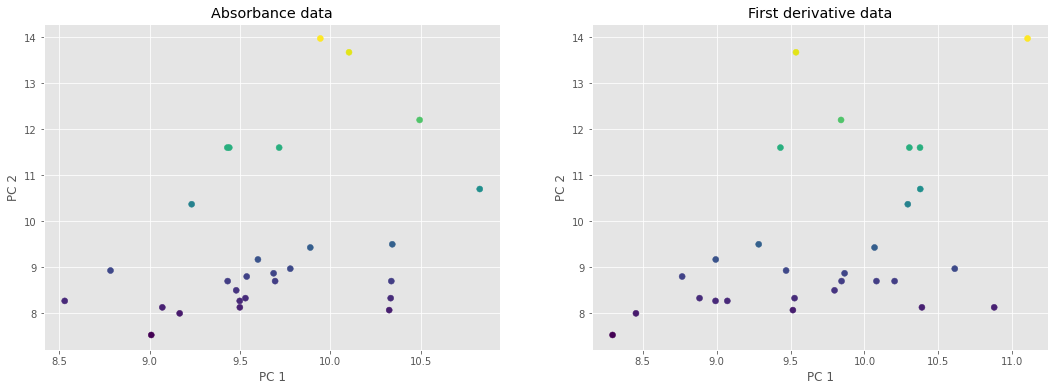

In [ ]:
fit1= plsX.transform(X_test)
fit2= plsX.transform(dX_test)

Ypred=linearfit1.predict(fit1)
dYpred=linearfit2.predict(fit2)

print("R^2 of the normal data is "+str(polyfit(Ypred,Y_test)))
print("R^2 of the derivative 1 data is "+str(polyfit(dYpred,dY_test)))

print("MSE of the normal data is "+str(mean_squared_error(Ypred,Y_test)))
print("MSE of the derivative 1 data is "+str(mean_squared_error(dYpred,dY_test)))

print("RMSE of the normal data is "+str(sqrt(mean_squared_error(Ypred,Y_test))))
print("RMSE of the derivative 1 data is "+str(sqrt(mean_squared_error(dYpred,dY_test))))

print("MAE of the normal data is "+str(mean_absolute_error(Ypred,Y_test)))
print("MAE of the derivative 1 data is "+str(mean_absolute_error(dYpred,dY_test)))

print("MAPE of the normal data is "+str(mean_absolute_percentage_error(Ypred,Y_test)))
print("MAPE of the derivative 1 data is "+str(mean_absolute_percentage_error(dYpred,dY_test)))



with plt.style.context('ggplot'):
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
      fig.set_tight_layout(False)
      print(fit1.T.shape)
      CS=ax1.scatter(Ypred,Y_test,c=Y_test)
      ax1.set_xlabel("PC 1")
      ax1.set_ylabel("PC 2")
      CS2=ax2.scatter(dYpred,dY_test,c=dY_test)
      ax2.set_xlabel("PC 1")
      ax2.set_ylabel("PC 2")
      ax1.set_title("Absorbance data")
      ax2.set_title("First derivative data")
      plt.show()

After training and testing O-PLS using partial least square as a Model, we got our baseline model. We will now proceeds to train and test various other model to see there are any better approaches. The list of below will be the models that we will test (test models will be added :
 - Linear Regression using O-PLS.
 - PLS without orthogonal signal correction.


#Testing ground

Here is where we are going to test the listed models will test it the same as we test the baseline model to see if their performance is comparable. 

<strong>Linear Regresssion with O-PLS. </strong>

One of the first approach we will try is Linear Regression, the most basic machine learning regression model. This test is to see whether using PLS have any improvements comparing to the basic models, and to test how much OSC improves that data.


In [ ]:
X_train, X_test, Y_train, Y_test  = train_test_split(X,Y,test_size = 0.3,random_state = 1)
dX_train, dX_test, dY_train, dY_test  = train_test_split(dX,Y,test_size = 0.3,random_state = 1)
opls_gen_X_test =  OPLS(n_components=10)
opls_gen_dX_test =  OPLS(n_components=10)
opls_gen_X_test = opls_gen_X_test.fit(X_train,Y_train)
opls_gen_dX_test = opls_gen_dX_test.fit(dX_train,Y_train)
X_opls_test = opls_gen_X_test.transform(X_train)
dX_opls_test = opls_gen_dX_test.transform(dX_train)

R^2 of the normal data is 0.9770125457500443
R^2 of the derivative 1 data is 0.8432430272056519
MSE of the normal data is 0.059678033035567596
MSE of the derivative 1 data is 0.40695884369165086
RMSE of the normal data is 0.24429087792131657
RMSE of the derivative 1 data is 0.6379332595904142
MAE of the normal data is 0.19841337354118088
MAE of the derivative 1 data is 0.4965251520831625
MAPE of the normal data is 0.12891065834361626
MAPE of the derivative 1 data is 0.13236369826819464
(2, 64)


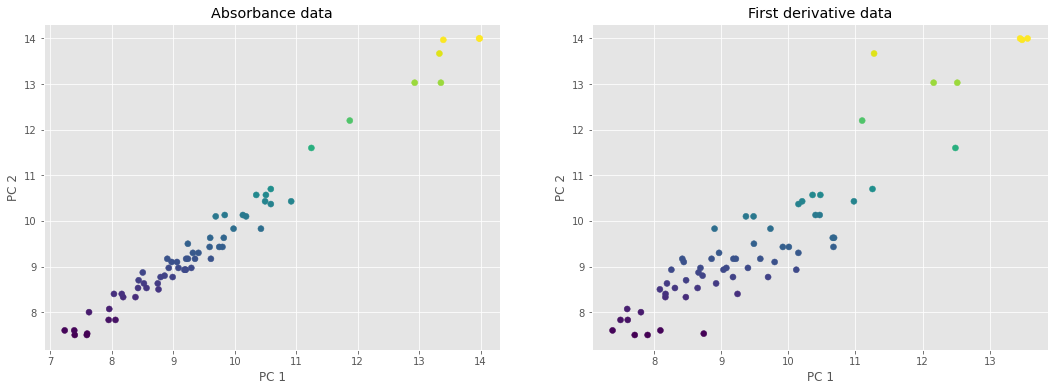

In [ ]:
fit1og = X_opls_test
fit2og = dX_opls_test

### we are now going to apply PLS after O-PLS since this 
### OPLS model only removes orthoganal variables and not truly O-PLS
plsX = PLS()
plsdX = PLS()

plsX.fit(fit1og,Y_train)
plsdX.fit(fit2og,dY_train)
fit1 = plsX.transform(fit1og)
fit2 = plsdX.transform(fit2og)
linearfit1 =LinearRegression()
linearfit2 = LinearRegression()

linearfit1.fit(fit1,Y_train)
linearfit2.fit(fit2,dY_train)

Ypred=linearfit1.predict(fit1)
dYpred=linearfit2.predict(fit2)
print("R^2 of the normal data is "+str(polyfit(Ypred,Y_train)))
print("R^2 of the derivative 1 data is "+str(polyfit(dYpred,dY_train)))

print("MSE of the normal data is "+str(mean_squared_error(Ypred,Y_train)))
print("MSE of the derivative 1 data is "+str(mean_squared_error(dYpred,dY_train)))

print("RMSE of the normal data is "+str(sqrt(mean_squared_error(Ypred,Y_train))))
print("RMSE of the derivative 1 data is "+str(sqrt(mean_squared_error(dYpred,dY_train))))

print("MAE of the normal data is "+str(mean_absolute_error(Ypred,Y_train)))
print("MAE of the derivative 1 data is "+str(mean_absolute_error(dYpred,dY_train)))

print("MAPE of the normal data is "+str(mean_absolute_percentage_error(Ypred,Y_train)))
print("MAPE of the derivative 1 data is "+str(mean_absolute_percentage_error(dYpred,dY_train)))



with plt.style.context('ggplot'):
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
      fig.set_tight_layout(False)
      print(fit1.T.shape)
      CS=ax1.scatter(Ypred,Y_train,c=Y_train)
      ax1.set_xlabel("PC 1")
      ax1.set_ylabel("PC 2")
      CS2=ax2.scatter(dYpred,dY_train,c=dY_train)
      ax2.set_xlabel("PC 1")
      ax2.set_ylabel("PC 2")
      ax1.set_title("Absorbance data")
      ax2.set_title("First derivative data")
      plt.show()

R^2 of the normal data is 0.140973791509116
R^2 of the derivative 1 data is 0.014149143785529361
MSE of the normal data is 3.3136252471929017
MSE of the derivative 1 data is 2.9016945094968336
RMSE of the normal data is 1.8203365752500007
RMSE of the derivative 1 data is 1.70343608905554
MAE of the normal data is 1.4855790320316842
MAE of the derivative 1 data is 1.39319223542569
MAPE of the normal data is 0.1405966123828961
MAPE of the derivative 1 data is 0.14267839455637077
(2, 28)


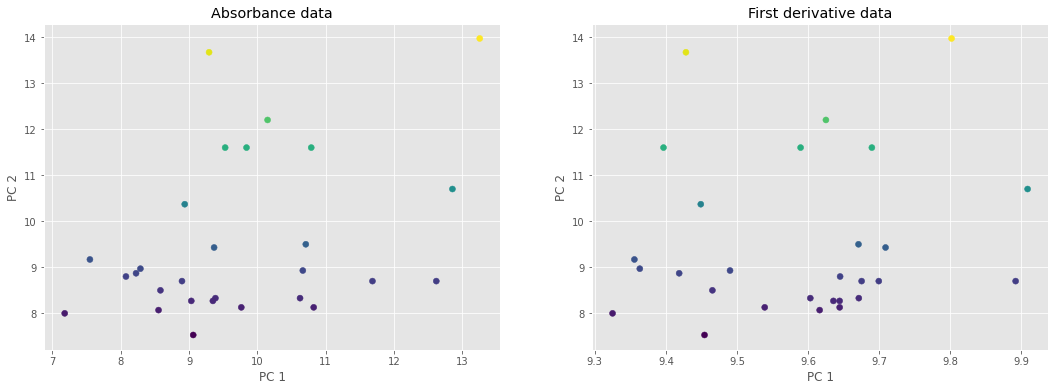

In [ ]:
X_opls_test = opls_gen_X_test.transform(X_test)
dX_opls_test = opls_gen_dX_test.transform(dX_test)

fit1og = X_opls_test
fit2og = dX_opls_test

### we are now going to apply PLS after O-PLS since this 
### OPLS model only removes orthoganal variables and not truly O-PLS

fit1 = plsX.transform(fit1og)
fit2 = plsdX.transform(fit1og)

Ypred=linearfit1.predict(fit1)
dYpred=linearfit2.predict(fit2)
print("R^2 of the normal data is "+str(polyfit(Ypred,Y_test)))
print("R^2 of the derivative 1 data is "+str(polyfit(dYpred,dY_test)))

print("MSE of the normal data is "+str(mean_squared_error(Ypred,Y_test)))
print("MSE of the derivative 1 data is "+str(mean_squared_error(dYpred,dY_test)))

print("RMSE of the normal data is "+str(sqrt(mean_squared_error(Ypred,Y_test))))
print("RMSE of the derivative 1 data is "+str(sqrt(mean_squared_error(dYpred,dY_test))))

print("MAE of the normal data is "+str(mean_absolute_error(Ypred,Y_test)))
print("MAE of the derivative 1 data is "+str(mean_absolute_error(dYpred,dY_test)))

print("MAPE of the normal data is "+str(mean_absolute_percentage_error(Ypred,Y_test)))
print("MAPE of the derivative 1 data is "+str(mean_absolute_percentage_error(dYpred,dY_test)))



with plt.style.context('ggplot'):
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
      fig.set_tight_layout(False)
      print(fit1.T.shape)
      CS=ax1.scatter(Ypred,Y_test,c=Y_test)
      ax1.set_xlabel("PC 1")
      ax1.set_ylabel("PC 2")
      CS2=ax2.scatter(dYpred,dY_test,c=dY_test)
      ax2.set_xlabel("PC 1")
      ax2.set_ylabel("PC 2")
      ax1.set_title("Absorbance data")
      ax2.set_title("First derivative data")
      plt.show()

<strong> Partial Least Square without OSC </strong>

In this section we will try Partial Least Square without using OSC to also see whether or not OSC helps with the data preprocssing phase without overfit the data.

In [ ]:
X_train, X_test, Y_train, Y_test  = train_test_split(X,Y,test_size = 0.3,random_state = 1)
dX_train, dX_test, dY_train, dY_test  = train_test_split(dX,Y,test_size = 0.3,random_state = 1)

R^2 of the normal data is 0.10895158161890005
R^2 of the derivative 1 data is 0.32678003142232803
MSE of the normal data is 2.313262546179533
MSE of the derivative 1 data is 4582.209043338751
RMSE of the normal data is 1.5209413355483286
RMSE of the derivative 1 data is 67.69201609745976
MAE of the normal data is 1.0976438430550406
MAE of the derivative 1 data is 67.67226274264956
MAPE of the normal data is 0.11303362529623795
MAPE of the derivative 1 data is 0.8762289891174777
(2, 28)


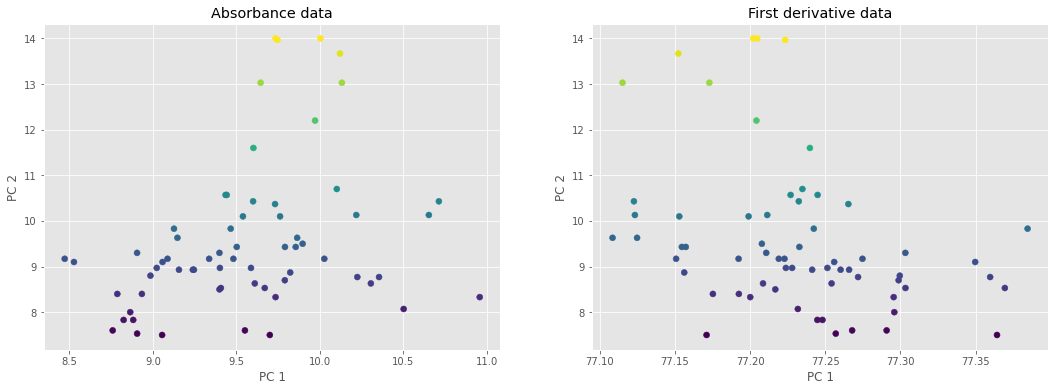

In [ ]:
fit1og = X_train
fit2og = dX_train

### we are now going to apply PLS after O-PLS since this 
### OPLS model only removes orthoganal variables and not truly O-PLS
plsX = PLS()
plsdX = PLS()

plsX.fit(fit1og,Y_train)
plsdX.fit(fit2og,dY_train)

Ypred=plsX.predict(fit1og)
dYpred=plsX.predict(fit2og)
print("R^2 of the normal data is "+str(plsX.score(fit1og,Y_train)))
print("R^2 of the derivative 1 data is "+str(plsdX.score(fit2og,Y_train)))


print("MSE of the normal data is "+str(mean_squared_error(Ypred,Y_train)))
print("MSE of the derivative 1 data is "+str(mean_squared_error(dYpred,dY_train)))

print("RMSE of the normal data is "+str(sqrt(mean_squared_error(Ypred,Y_train))))
print("RMSE of the derivative 1 data is "+str(sqrt(mean_squared_error(dYpred,dY_train))))

print("MAE of the normal data is "+str(mean_absolute_error(Ypred,Y_train)))
print("MAE of the derivative 1 data is "+str(mean_absolute_error(dYpred,dY_train)))

print("MAPE of the normal data is "+str(mean_absolute_percentage_error(Ypred,Y_train)))
print("MAPE of the derivative 1 data is "+str(mean_absolute_percentage_error(dYpred,dY_train)))



with plt.style.context('ggplot'):
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
      fig.set_tight_layout(False)
      print(fit1.T.shape)
      CS=ax1.scatter(Ypred,Y_train,c=Y_train)
      ax1.set_xlabel("PC 1")
      ax1.set_ylabel("PC 2")
      CS2=ax2.scatter(dYpred,dY_train,c=dY_train)
      ax2.set_xlabel("PC 1")
      ax2.set_ylabel("PC 2")
      ax1.set_title("Absorbance data")
      ax2.set_title("First derivative data")
      plt.show()

R^2 of the normal data is 0.11697795068674433
R^2 of the derivative 1 data is 0.1466655170745712
MSE of the normal data is 2.59443771854613
MSE of the derivative 1 data is 2.507211649765263
RMSE of the normal data is 1.6107258359342629
RMSE of the derivative 1 data is 1.5834177117126305
MAE of the normal data is 1.3306419627115986
MAE of the derivative 1 data is 1.2766556937014022
MAPE of the normal data is 0.13644695169899557
MAPE of the derivative 1 data is 0.1251191563977748
(2, 28)


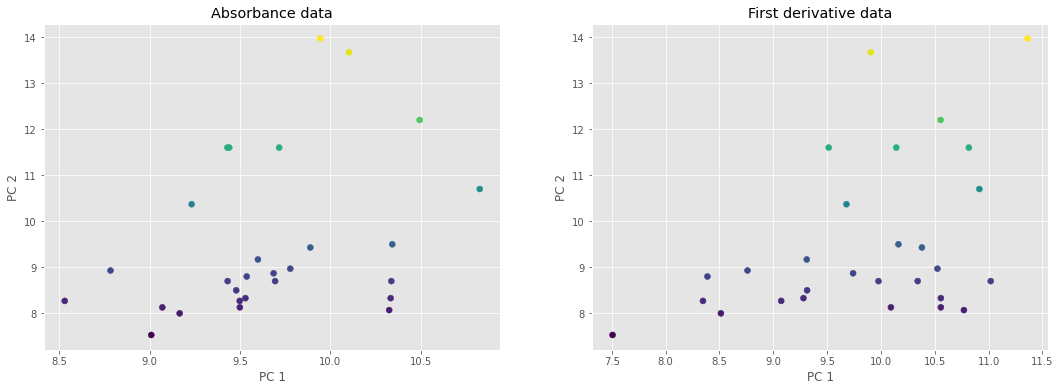

In [ ]:
X_opls_test = X_test
dX_opls_test =dX_test

fit1og = X_opls_test
fit2og = dX_opls_test

### we are now going to apply PLS after O-PLS since this 
### OPLS model only removes orthoganal variables and not truly O-PLS

print("R^2 of the normal data is "+str(plsX.score(fit1og,Y_test)))
print("R^2 of the derivative 1 data is "+str(plsdX.score(fit2og,dY_test)))


Ypred=plsX.predict(fit1og)
dYpred=plsdX.predict(fit2og)
print("MSE of the normal data is "+str(mean_squared_error(Ypred,Y_test)))
print("MSE of the derivative 1 data is "+str(mean_squared_error(dYpred,dY_test)))

print("RMSE of the normal data is "+str(sqrt(mean_squared_error(Ypred,Y_test))))
print("RMSE of the derivative 1 data is "+str(sqrt(mean_squared_error(dYpred,dY_test))))

print("MAE of the normal data is "+str(mean_absolute_error(Ypred,Y_test)))
print("MAE of the derivative 1 data is "+str(mean_absolute_error(dYpred,dY_test)))

print("MAPE of the normal data is "+str(mean_absolute_percentage_error(Ypred,Y_test)))
print("MAPE of the derivative 1 data is "+str(mean_absolute_percentage_error(dYpred,dY_test)))
fit1 = plsX.transform(fit1og)
fit2 = plsdX.transform(fit1og)


with plt.style.context('ggplot'):
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
      fig.set_tight_layout(False)
      print(fit1.T.shape)
      CS=ax1.scatter(Ypred,Y_test,c=Y_test)
      ax1.set_xlabel("PC 1")
      ax1.set_ylabel("PC 2")
      CS2=ax2.scatter(dYpred,dY_test,c=dY_test)
      ax2.set_xlabel("PC 1")
      ax2.set_ylabel("PC 2")
      ax1.set_title("Absorbance data")
      ax2.set_title("First derivative data")
      plt.show()